<a id='final_project'></a>

# CS109 Final Project


## Title: A Real-Bogus Detection Classifier for Pan-STARRS-1 Astronomical Data

![Pan-STARRS](ps1.PNG)

Team: The Real-Bogus Classifiers

Chris Apgar <apgar@g.harvard.edu>

Matthew Holman <mholman@cfa.harvard.edu>

Freddy Vallenilla <fvallenilladorta@g.harvard.edu>

Evan Zimmerman <zimmerman@college.harvard.edu>


#Table of Contents
* [CS109 Final Project](#final_project)
    * [Overview and Motivation](#overview)
    * [Related Work](#related)
	* [Data Wrangling & EDA](#data_wrangling)
    * [Model Selection](#model_selection)
    * [Cost & Profit Curves](#cost_profit)
    * [Final Analysis](#analysis)
    * [Acknowledgements](#acknowledgements)


<a id='overview'></a>
## Overview and Motivation

Pan-STARRS is a 1.8m telescope on Hale'akala, Maui, that is repeatedly imaging the night sky. The primary input is files of the detections of sources (stars, galaxies, asteroids, comets, etc) in each of the Pan-STARRS images. The image processing and source detection is done by the Pan-STARRS Image Processing Pipeline. We will take the results, which are FITS files with tables of detections. One of the first stages is to remove known stationary sources from the input. These are stars and galaxies.  Any detection that lands with 0.5 arcsec of a known stationary source is filtered out.  Each exposure contains about 10^5 detections. Roughly 80-90% of those will coincide with a known source.

The remaining 10-20% are "non-stationary" detections, which form the input to the downstream moving object pipeline. However, the vast majority of those 10-20% are false detections (detector defects, scattered light, noise fluctuations, etc.) Out of the 10^4 to 2x10^4 non-stationary detections, only about 200 are actually real moving objects, mostly main belt asteroids. Because the speed of the search depends at all stages on the number of detections, eliminating false detections would be a big win.

We are building a real-bogus classifier. Every detection comes with tens of features (location, brightness, filter, shape parameters, and a long list of flags from the Image Processing Pipeline). Even better, each exposure comes with its own training set. That is the 80-90% of the detections that coincide with a known source and are likely to be real. Each of those detections has the same set of features. The rest of the detections are most likely false. It is not a perfectly pure training set, but it is a good start. And there is a huge number of exposures to use for training. The result is important enough that it could possibly be published in an astronomy journal if the classifier is good. It also has a lot of practical implications if we can find a good single-exposure classifier, because it would lower the amount of junk downstream software has to process (which would make it run faster and more accurately).


<a id='related'></a>
## Related Work

One of our team members, Matthew Holman, is an astronomer and the interim director of the Minor Planetary Center at Harvard.

...

<a id='data_wrangling'></a>
## Data Wrangling and Exploratory Data Analysis

The data is a series of exposures (basically, pictures) from the Pan-STARRS telescope. We will be using preprocessed data from the Pan-STARRS image processing pipeline. We also have a catalog of known stationary sources (determined from the exposures themselves) and a catalog of known moving objects from the Minor Planet Center.  Each exposure contains roughly one hundred thousand “observations” (rows). The observations contain dozens of characteristics (columns).  Within each exposure there should be several hundred moving objects (asteroids).

This notebook will focus on the process of collecting the data, putting it into a form that is convenient for our work as a team, and exploring the trends that might inform a more detailed analysis.


In [268]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [269]:
import sys, math, commands, os
from math import degrees
import ephem
from astropy.io import fits
from scipy import spatial
#import healpy as hp
import warnings
import collections
import json

ERROR! Session/line number was not unique in database. History logging moved to new session 118


Here are some additional python modules that need to be loaded.  These should be accessible with the anaconda python distribution, but we'll find out for sure.

I needed to type

> pip install ephem

> pip install healpy

at the command line.  

Something failed with the healpy installation; need to sort that out.  
Tried

> pip install healpy==1.8.6

> pip install healpy==1.6.3

Same problems.

The healpy routines are only needed for managing the catalogs of known sources.  What I can do to circumvent the problem is to run a version of this on the odyssey cluster (where healpy works fine).  All we need to know is whether a given detection in the smf file coincides on the sky with a source in the catalogs.  I'll try to add a column to the tables in the smf files that as a 1 if the detection coincides with known source, and 0 if not.  Once we have that column, we no longer need the healpy routines.

Ok, I sorted this out.  It turns out I had an old xcode developer package in /Developer on my mac.  That was interfering with the healpy installation.  Regardless, we probably won't need this package.


In [270]:
# Here are various utility routines.

def sunradec(jd):
    day = jd -2415020
    sun = ephem.Sun(day)
    return degrees(sun.a_ra), degrees(sun.a_dec)

# =============================
# JD Convertor (use pyephem)
# This piece came from one of Ed's codes.
# =============================
def date2JD(Cinput):
    #2010-07-22T10:17:00.187239
    Cinput=str(Cinput)
    Cdate = Cinput.split('T')[0]
    Ctime = Cinput.split('T')[1]
    Cyear = Cdate.split('-')[0]
    Cmonth= Cdate.split('-')[1]
    Cday  = Cdate.split('-')[2]
    d = ephem.Date('%s/%s/%s %s' %(Cyear,Cmonth,Cday,Ctime))
    #print '%s/%s/%s %s' %(Cyear,Cmonth,Cday,Ctime)
    #print float(d)+2415020
    return float(d)+2415020


def get_deteff(hdu, zpt_obs, exptime):
    #print hdu.columns
    #print hdu.data
    mag_ref = hdu.header["DETEFF.MAGREF"]
    count_max = hdu.header["DETEFF.NUM"]
    mag_limit = mag_ref + zpt_obs + 2.5*math.log10(exptime)
    results = []
    for offset, count, diff_mean, diff_stdev, err_mean in hdu.data:
        results.append((offset, count, diff_mean, diff_stdev, err_mean))
    return (mag_limit, count_max, results)

def det_eff_func(x, a, b, c):
    return a*0.5*(1.0-np.tanh((x-b)/c))

# This is not used.
def adjustnan(x):
    if(np.isnan(x) or np.isinf(x)):
        return 99.0
    else:
        return x

def pick_mag(x, y):
    if(not(np.isnan(x)) and not(np.isinf(x))):
        return x
    else:
        return y

def xfold(x, xgap=8, ygap=10):
    nx = x%(600+xgap)
    return nx

def yfold(y, xgap=8, ygap=10):
    ny = y%(600+ygap)
    return ny

def mag_err2snr(mag_err):
    nsr = 1.0 - math.pow(10.0, -0.4*math.fabs(mag_err))
    if(nsr != 0.0):
        snr = 1.0/nsr
    else:
        small_err = 0.0001
        nsr = 1.0 - math.pow(10.0, -0.4*small_err)
        snr = 1.0/nsr
    return snr

def inBox(x, y, xgap=8, ygap=10, xmin=10, xmax=580, ymin=5, ymax=585):
    x_fold = xfold(x, xgap=xgap, ygap=ygap)
    y_fold = yfold(y, xgap=xgap, ygap=ygap)
    # This is what it was initially.
    #inbox = (10 < x_fold < 582 and 5 < y_fold < 589)
    # Then I tried this.
    #inbox = (10 < x_fold < 580 and 5 < y_fold < 585)
    # If I use extremely agressive masking like this, 
    # then I can get rid of the remaining striping.
    # That implies to me that some of the chips have defect 
    # regions that are much farther from the edges.
    #inbox = (200 < x_fold < 400 and 200 < y_fold < 400)
    # It seems that the x cut is more critical than the y cut.
    inbox = (xmin < x_fold < xmax and ymin < y_fold < ymax)
    return inbox

def xfold_dm(x, xgap=8, ygap=10):
    cx, nx = divmod(x, (600+xgap))
    return cx, nx

def yfold_dm(y, xgap=8, ygap=10):
    cy, ny = divmod(y,(600+ygap))
    return cy, ny

def whichCell(x, y, xgap=8, ygap=10, xmin=10, xmax=580, ymin=5, ymax=585):
    cx, nx = xfold_dm(x, xgap=xgap, ygap=ygap)
    cy, ny = yfold_dm(y, xgap=xgap, ygap=ygap)
    return cy, cx

def magOK(mag, mag_err):
    mag_bad = np.isnan(mag) or np.isinf(mag) or np.isnan(mag_err) or np.isinf(mag_err)
    return not(mag_bad)

def flagOK(flag):
    return (0x1003bc88 & int(flag)) == 0

def poorFlag(flag):
    return (0xe0440130 & int(flag)) != 0


In [271]:
whichCell(460.2, 240.5)

(0.0, 0.0)

In [272]:
# Based on clever trick on
# http://stackoverflow.com/questions/9630563/bitmask-parsing-in-python-using-only-standard-library
#
def parse_flags(flag, size=32):
    return [bool(flag & (1 << size - i - 1)) for i in xrange(size)]
            
#parse_flags(0xF0F0F0F0)

FLAGS_dict = {
    'DEFAULT' :  0x00000000, # Initial value: resets all bits
    'PSFMODEL':  0x00000001, # Source fitted with a psf model (linear or non-linear)
    'EXTMODEL':  0x00000002, # Source fitted with an extended-source model
    'FITTED'  :  0x00000004, # Source fitted with non-linear model (PSF or EXT; good or bad)
    'FITFAIL' :  0x00000008, # Fit (non-linear) failed (non-converge, off-edge, run to zero)
    'POORFIT' :  0x00000010, # Fit succeeds, but low-SN, high-Chisq, or large (for PSF -- drop?)
    'PAIR'    :  0x00000020, # Source fitted with a double psf
    'PSFSTAR' :  0x00000040, # Source used to define PSF model
    'SATSTAR' :  0x00000080, # Source model peak is above saturation
    'BLEND'   :  0x00000100, # Source is a blend with other sourcers
    'EXTERNALPOS':  0x00000200, # Source based on supplied input position
    'BADPSF'   :  0x00000400, # Failed to get good estimate of object's PSF
    'DEFECT'   :  0x00000800, # Source is thought to be a defect
    'SATURATED':  0x00001000, # Source is thought to be saturated pixels (bleed trail)
    'CR_LIMIT' :  0x00002000, # Source has crNsigma above limit
    'EXT_LIMIT':  0x00004000, # Source has extNsigma above limit
    'MOMENTS_FAILURE':  0x00008000, # could not measure the moments
    'SKY_FAILURE'    :  0x00010000, # could not measure the local sky
    'SKYVAR_FAILURE' :  0x00020000, # could not measure the local sky variance
    'MOMENTS_SN'     :  0x00040000, # moments not measured due to low S/N
    'UNDEFINED'      :  0x00080000, # this bit is not defined
    'BIG_RADIUS'     :  0x00100000, # poor moments for small radius, try large radius
    'AP_MAGS'        :  0x00200000, # source has an aperture magnitude
    'BLEND_FIT'      :  0x00400000, # source was fitted as a blend
    'EXTENDED_FIT'   :  0x00800000, # full extended fit was used
    'EXTENDED_STATS' :  0x01000000, # extended aperture stats calculated
    'LINEAR_FIT'     :  0x02000000, # source fitted with the linear fit
    'NONLINEAR_FIT'  :  0x04000000, # source fitted with the non-linear fit
    'RADIAL_FLUX'    :  0x08000000, # radial flux measurements calculated
    'SIZE_SKIPPED'   :  0x10000000, # Warning:: if set, size could be determined
    'ON_SPIKE'       :  0x20000000, # peak lands on diffraction spike
    'ON_GHOST'       :  0x40000000, #peak lands on ghost or glint
    'OFF_CHIP'       :  0x80000000 #peak lands off edge of chip
    }

badlist  = ['FITFAIL', 'SATSTAR', 'BADPSF', 'DEFECT', 'SATURATED', 'CR_LIMIT', 'MOMENTS_FAILURE', 'SKY_FAILURE', 'SKYVAR_FAILURE', 'SIZE_SKIPPED']
poorlist = ['POORFIT', 'PAIR', 'BLEND', 'MOMENTS_SN', 'BLEND_FIT', 'ON_SPIKE', 'ON_GHOST', 'OFF_CHIP']

badflags = 0
for k in badlist:
    badflags += FLAGS_dict[k]
print "bad: %x" %  (badflags)

poorflags = 0
for k in poorlist:
    poorflags += FLAGS_dict[k]
print "poor: %x" % (poorflags)

FLAGS2_dict = {
    'DIFF_WITH_SINGLE': 0x00000001, # diff source matched to a single positive detection
    'DIFF_WITH_DOUBLE': 0x00000002, # diff source matched to positive detections in both images
    'MATCHED'         : 0x00000004, # source was supplied at this location from somewhere else (eg, another image, forced photometry location, etc)
    'ON_SPIKE'        : 0x00000008, # > 25% of (PSF-weighted) pixels land on diffraction spike
    'ON_STARCORE'     : 0x00000010, # > 25% of (PSF-weighted) pixels land on star core
    'ON_BURNTOOL'     : 0x00000020, # > 25% of (PSF-weighted) pixels land on burntool subtraction region
    'ON_CONVPOOR'     : 0x00000040, # > 25% of (PSF-weighted) pixels land on region where convolution had substantial masked fraction contribution
    'PASS1_SRC'       : 0x00000080, # source was detected in the first pass of psphot (bright detection stage)
    'HAS_BRIGHTER_NEIGHBOR': 0x00000100, # peak is not the brightest in its footprint
    'BRIGHT_NEIGHBOR_1'    : 0x00000200, # flux_n / (r2 flux_p) > 1
    'BRIGHT_NEIGHBOR_10'   : 0x00000400, # flux_n / (r2 flux_p) > 10
    'DIFF_SELF_MATCH'      : 0x00000800, # positive detection match is probably this source
    'SATSTAR_PROFILE'      : 0x00001000 # saturated source is modeled with a radial profile
}


bad: 1003bc88
poor: e0440130


The bit values of FLAGS and FLAGS2 are defined here:

http://svn.pan-starrs.ifa.hawaii.edu/trac/ipp/wiki/CMF_PS1_V3

The routine below processes a FITS file.  The end goal is to put the data into a pandas dataframe that can be used by the rest of the team for classification experiments.

The information that we have so far is:

0) The features that are common to all of the detections in the smf file.
1) The features that come with each detection.
2) Whether a detection coincides with a known stationary source.

Among the features that come with each detection are FLAGS and FLAGS2.  These are bitmasks that encode information from the Image Processing Pipeline.  Some of these are designated as 'poor'; they indicate that something is less than ideal about the fit, but the fit did not fail.  Others are designated as 'bad'; they indicate a failure.

```
Here is the information about the flags from Magnier et al. (2013):

FAIL             0x00000008 # Bad Fit (nonlinear) failed (non-converge, off-edge, run to zero)
POOR             0x00000010 # Poor Fit succeeds, but low-SN or high-Chisq
PAIR             0x00000020 # Poor Source fitted with a double psf
SATSTAR          0x00000080 # Bad Source model peak is above saturation
BLEND            0x00000100 # Poor Source is a blend with other sources
BADPSF           0x00000400 # Bad Failed to get good estimate of object’s PSF
DEFECT           0x00000800 # Bad Source is thought to be a defect
SATURATED        0x00001000 # Bad Source is thought to be saturated pixels (bleed trail)
CR_LIMIT         0x00002000 # Bad Source has crNsigma above limit
EXT_LIMIT        0x00004000 # Source has extNsigma above limit (Not bad)
MOMENTS_FAILURE  0x00008000 # Bad Could not measure the moments
SKY_FAILURE      0x00010000 # Bad Could not measure the local sky
SKYVAR_FAILURE   0x00020000 # Bad Could not measure the local sky variance
BELOW_MOMENTS_SN 0x00040000 # Poor Moments not measured due to low S/N
BLEND_FIT        0x00400000 # Poor Source was fitted as a blend
SIZE_SKIPPED     0x10000000 # Bad Size could not be determined
ON_SPIKE         0x20000000 # Poor Peak lands on diffraction spike
ON_GHOST         0x40000000 # Poor Peak lands on ghost or glint
OFF_CHIP         0x80000000 # Poor Peak lands off edge of chip

The sum of the bits that correspond to a 'bad' flag is:
                 0x1003bc88
                 
The sum of the bits that correspond to a 'poor' flag is:               
                 e0440130
                 
A very typical flag looks like:
                 0x02204001
 
```
                 
This means a linear fit was completed, with aperture magnitudes, extNsigma above the limit, with a psf model.  (nSigma deviations from psf to ext)

More information is available at:               
http://svn.pan-starrs.ifa.hawaii.edu/trac/ipp/wiki/CMF_PS1_V3

These things indicate that a detection is suspicious:

    * One of the "bad flag" bits is set

    * SNR < 5

    * PSF_QF_PERFECT < 0.4 or 0.5

    * detection is near the edge of a cell

There are a bunch of other features that might be relevant:

    * psf_npix

    * PSF_QF


In [273]:
# This routine opens a FITS file named infile and processes it.
# MJH: do we need to include this function, given that we use
# smf2pandas?

def process_file(infile, outfile, headerfile, txtfile):
    tfile = open(txtfile, "w")
    with fits.open(infile) as hdulist:

        warnings.resetwarnings()
        warnings.filterwarnings('ignore', category=UserWarning, append=True)

        # Collect some primary header information
        zpt_obs  = hdulist[0].header["ZPT_OBS"]
        filterID = hdulist[0].header["FILTERID"].rstrip('.00000')
        ra_c     = hdulist[0].header["RA"]
        dec_c    = hdulist[0].header["DEC"]
        exptime  = hdulist[0].header["EXPTIME"]
        mjdObs   = hdulist[0].header["MJD-OBS"]
        airmass  = hdulist[0].header["AIRMASS"]
    
        # Do a few calculations
        jd = mjdObs + 2400000.5
        sun_ra = sunradec(jd)[0]
        sun_dec = sunradec(jd)[1]

        snr_thresh = 5.0
        qfp_thresh = 0.4
        search_radius = 1.6*math.pi/180.
        '''
        tree = get_catalog_tree(ra_c, dec_c, search_radius)
        if tree == None:
            return None
        '''

        print filterID

        reject = 0
        bad = 0
        on_edge = 0
        low_snr = 0
        on_star_count = 0
        qfp_count = 0
        j = 0
        nrows_total = 0
        newhdus = []
        shutoutc = None
        ra_all = np.empty([])
        dec_all = np.empty([])
        x_all = np.empty([])
        y_all = np.empty([])
        
        det_eff_dict = {}
        chip_dict = {}
        
        for hdu in hdulist:
            #print hdu.name
            ext_type = hdu.name.split('.')[-1]
            if ext_type == 'deteff':
                #print hdu.header
                chip=hdu.header['EXTHEAD'].rstrip('.hdr')
                # One of the detection efficiency extensions.
                # We'll want to do something with this information.
                det_eff_tup = get_deteff(hdu, zpt_obs, exptime)
                det_eff_dict[chip] = det_eff_tup
                #offs = np.array(map(lambda v: v[0], det_eff_tup[2]), dtype=np.float64)
                #popt, pv = sp.optimize.curve_fit(det_eff_func, offs, fracs, p0=[0.5, 0.0, 0.3], sigma=mean_errs)

            elif ext_type == 'hdr':
                # One of the psf postage stamp extensions
                # We can get shutoutc from here, but we
                # only need to do that once.
                if shutoutc == None:
                    try:
                        shutoutc = hdu.header['SHUTOUTC']
                        shutcutc = hdu.header['SHUTCUTC']
                    except Exception,e:
                        pass
            
            elif ext_type == 'psf' and "EXTTYPE" in hdu.header and (hdu.header["EXTTYPE"] == "PS1_V3"):
            # One of the extensions with tables of detections.
            # This holds our primary data.
                chip=hdu.header['EXTHEAD'].rstrip('.hdr')
                hdu_name = hdu.name.split('.')[0]
                nrows = hdu.header['NAXIS2']
                nrows_total = nrows_total + nrows

                col_dict = {}
                series_dict = {}
                #print hdu.columns.names
                for col in hdu.columns.names:
                    col_dict[col] = hdu.data.field(col)
                    series_dict[col] = pd.Series(hdu.data.field(col).byteswap().newbyteorder())
                
                hdu_df = pd.DataFrame.from_dict(series_dict)
                chip_dict[chip] = hdu_df
                
                ras  = col_dict['RA_PSF']
                decs = col_dict['DEC_PSF']
                xs   = col_dict['X_PSF']
                ys   = col_dict['Y_PSF']
                x_sigs   = col_dict['X_PSF_SIG']
                y_sigs   = col_dict['Y_PSF_SIG']
                plts = col_dict['PLTSCALE']
                mag0s= col_dict['CAL_PSF_MAG']
                mag1s= col_dict['PSF_INST_MAG'] + zpt_obs + 2.5*math.log10(exptime)
                mags = map(pick_mag, mag0s, mag1s)
                mag_errs = col_dict['PSF_INST_MAG_SIG']
                psf_minors= col_dict['PSF_MINOR']*plts
                psf_majors= col_dict['PSF_MAJOR']*plts
                flags    = col_dict['FLAGS']
                flags2   = col_dict['FLAGS2']
                fwhms = 2.3548 * np.sqrt(psf_majors*psf_minors)
                moments_R1s = col_dict['MOMENTS_R1']*plts
                psf_qf_perfects = col_dict['PSF_QF_PERFECT']
                psf_extents = (moments_R1s*moments_R1s)/(psf_majors*psf_minors)
                on_stars = col_dict['on_star']
                
                snrs = map(mag_err2snr, mag_errs)
                
                # There really are just a few calculations in the lines above.
                # All can easily be done on the resulting dataframes instead.
                #
                # mag1s convert from instrumental magnitude
                # mags to chose the best magnitude between mag0 and mag1
                # psf_minor, psf_major, and moments_R1 converted to arcseconds
                # psf_extent calculated (but this needs to be fixed)
                # SNR calculation

                #qpoints = convert_points(ras, decs)
                #idx_fr = tree.query_ball_point(qpoints, sr)
                #offStar_mask = [matches == [] for matches in idx_fr]

                inBox_mask = [inBox(x, y) for x, y in zip(xs, ys)]
                magOK_mask = [magOK(mag, mag_err) for mag, mag_err in zip(mags, mag_errs)]
                qfp_mask   = [qfp >= qfp_thresh for qfp in psf_qf_perfects]
                offStar_mask = [on_star == 0 for on_star in on_stars]
                goodFlag_mask = [flagOK(flag) for flag in flags]
                snr_mask   = [snr >= snr_thresh for snr in snrs]

                mask = map(lambda u, v, w, x, y, z: (u and v and w and x and y and  z), inBox_mask, magOK_mask, offStar_mask, qfp_mask, goodFlag_mask, snr_mask)
                #mask = map(lambda x, y: (x and y), inBox_mask, magOK_mask)
                mask = np.array(mask)
                
                ra_all= np.append(ra_all, ras[mask])
                dec_all= np.append(dec_all, decs[mask])
                x_all= np.append(x_all, xs[mask])
                y_all= np.append(y_all, ys[mask])

                # Here we can check which detections are angularly close to known sources
                # by comparing to a catalog with a KD-tree.
                # 

                hdu.data = hdu.data[mask]

                for i, (ra, dec, x, y, x_sig, y_sig, mag, mag_err, fwhm, flag, flag2, psf_major, psf_minor, moments_R1, psf_qf_perfect, psf_extent, on_star) in enumerate(zip(ras, decs, xs, ys, x_sigs, y_sigs, mags, mag_errs, fwhms, flags, flags2, psf_majors, psf_minors, moments_R1s, psf_qf_perfects, psf_extents, on_stars)):
                    #if inBox_mask[i] and magOK_mask[i] and offStar_mask[i]:
                    #if inBox_mask[i] and magOK_mask[i]:
                    if True:
                        snr = mag_err2snr(mag_err)
                        #pix = ra_dec2pix(ra, dec, nside, nested=nested_scheme)
                        #pix = -1
                        #print flag
                        if (0x1003bc88 & int(flag)) != 0:
                            bad += 1
                            #print "|%32s" % ("{0:b}".format(int(flag)))
                            #print "|%32s" % ("{0:b}".format(0x1003bc88))
                            #print "|%32s" % ("{0:b}".format(0x1003bc88 & int(flag)))
                            #print parse_flags(int(flag))
                        if on_star==1:
                            on_star_count += 1
                        if psf_qf_perfect < qfp_thresh:
                            qfp_count +=1
                        if not(inBox_mask[i]):
                            on_edge +=1
                        if snr < snr_thresh:
                            low_snr +=1
                        if (0x1003bc88 & int(flag)) != 0 or snr < snr_thresh or not(inBox_mask[i]) or on_star or not(magOK_mask[i]) or psf_qf_perfect < qfp_thresh:
                            reject +=1
                        else:
                            wstring = "%d %lf %lf %lf %lf %x %s %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %.3lf %x %d %x %d %d\n" % \
                                (j, ra, dec, mag, mag_err, flag, chip, fwhm, snr, x, y, x_sig, y_sig, psf_major, psf_minor, moments_R1, psf_qf_perfect, psf_extent, flag2, on_star, (0x1003bc88 & int(flag)), psf_qf_perfect<0.5, inBox_mask[i])
                            tfile.write(wstring)

                    j = j+1

            elif hdu.name == 'PRIMARY':
                # One of the first extension.
                # There is nothing to do, at this point.
                pass
            
            elif hdu.name == 'MATCHED_REFS':
                # One of the first extension.
                # There is nothing to do, at this point.
                print hdu.columns.names
                col_dict = {}
                series_dict = {}
                #print hdu.columns.names
                for col in hdu.columns.names:
                    col_dict[col] = hdu.data.field(col)
                    series_dict[col] = pd.Series(hdu.data.field(col).byteswap().newbyteorder())
                matched_refs_df = pd.DataFrame.from_dict(series_dict)
                pass

            else:
                # Unknown type of extension.
                #print "Some other kind of extension " + hdu.name
                pass

            newhdus.append(hdu)

        thdulist = fits.HDUList(newhdus)
        thdulist.writeto(outfile, clobber=True, output_verify="silentfix")
        #print shutoutc
        shutoutc_jd = date2JD(shutoutc)
        output_txt = '%20.10f %6.3f %s %11.6f %12.6f %6.3f %8.4f %s %11.6f %12.6f' % (shutoutc_jd, exptime, str(filterID), ra_c, dec_c, airmass, zpt_obs, shutoutc, sun_ra, sun_dec)
        h = open(headerfile, 'w')
        h.write(output_txt+'\n')
        h.close()
        tfile.close()
        print "total rows: ", j
        print "reject:     ", reject
        print "bad:        ", bad
        print "on_star:    ", on_star_count
        print "low SNR:    ", low_snr
        print "on edge:    ", on_edge
        print "qfp bad:    ", qfp_count
        print "remaining:  ", j - reject
        return ra_all, dec_all, x_all, y_all, mask, chip_dict, det_eff_dict, matched_refs_df


In [274]:
# MJH: I should document and include the code that identifies the matching stationary
# sources and minor planets in these smf files.  Those matches underpin are a key ingredient
# to our classification system.
def smf2pandas(infile, snr_thresh=5.0, qfp_thresh=0.4, FLAGS_dict=None, FLAGS2_dict=None):

    with fits.open(infile) as hdulist:

        warnings.resetwarnings()
        warnings.filterwarnings('ignore', category=UserWarning, append=True)

        # Collect some primary header information
        ra_c     = hdulist[0].header["RA"]
        dec_c    = hdulist[0].header["DEC"]
        zpt_obs  = hdulist[0].header["ZPT_OBS"]
        filterID = hdulist[0].header["FILTERID"].rstrip('.00000')
        exptime  = hdulist[0].header["EXPTIME"]
        mjdObs   = hdulist[0].header["MJD-OBS"]
        airmass  = hdulist[0].header["AIRMASS"]
    
        # Do a few calculations
        jd = mjdObs + 2400000.5

        print filterID, ra_c, dec_c, mjdObs

        shutoutc = None
        
        chip_dict = {}
        
        for hdu in hdulist:
            #print hdu.name
            ext_type = hdu.name.split('.')[-1]
            if ext_type == 'deteff':
                #print hdu.header
                # One of the detection efficiency extensions.
                # We'll want to do something with this information.
                #det_eff_tup = get_deteff(hdu, zpt_obs, exptime)
                #popt, pv = sp.optimize.curve_fit(det_eff_func, offs, fracs, p0=[0.5, 0.0, 0.3], sigma=mean_errs)
                pass
            
            elif ext_type == 'hdr':
                # One of the psf postage stamp extensions
                # We can get shutoutc from here, but we
                # only need to do that once.
                if shutoutc == None:
                    try:
                        shutoutc = hdu.header['SHUTOUTC']
                        shutcutc = hdu.header['SHUTCUTC']
                    except Exception,e:
                        pass
            
            elif ext_type == 'psf' and "EXTTYPE" in hdu.header and (hdu.header["EXTTYPE"] == "PS1_V3"):
            # One of the extensions with tables of detections.
            # This holds our primary data.
                chip=hdu.header['EXTHEAD'].rstrip('.hdr')
                hdu_name = hdu.name.split('.')[0]

                col_dict = {}
                series_dict = {}
                #print hdu.columns.names
                for col in hdu.columns.names:
                    col_dict[col] = hdu.data.field(col)
                    series_dict[col] = pd.Series(hdu.data.field(col).byteswap().newbyteorder())
                
                chip_dict[chip] = pd.DataFrame.from_dict(series_dict)
                
                plts = col_dict['PLTSCALE']
                mag0s= col_dict['CAL_PSF_MAG']
                mag1s= col_dict['PSF_INST_MAG'] + zpt_obs + 2.5*math.log10(exptime)
                mags = map(pick_mag, mag0s, mag1s)
                mag_errs = col_dict['PSF_INST_MAG_SIG']
                psf_minors= col_dict['PSF_MINOR']
                psf_majors= col_dict['PSF_MAJOR']
                fwhms = 2.3548 * np.sqrt(psf_majors*psf_minors) * plts
                moments_xxs = col_dict['MOMENTS_XX']
                moments_yys = col_dict['MOMENTS_YY']
                psf_extents = np.sqrt((moments_xxs*moments_yys)/(psf_majors*psf_minors))
                snrs = map(mag_err2snr, mag_errs)
                
                sLength = len(chip_dict[chip].index)
                chip_dict[chip]['chip'] = pd.Series([chip]*sLength, index=chip_dict[chip].index)
                chip_dict[chip]['filterID'] = pd.Series([filterID]*sLength, index=chip_dict[chip].index)                
                chip_dict[chip]['mag'] = pd.Series(mags, index=chip_dict[chip].index)
                chip_dict[chip]['snr'] = pd.Series(snrs, index=chip_dict[chip].index)
                chip_dict[chip]['fwhm'] = pd.Series(fwhms, index=chip_dict[chip].index)
                chip_dict[chip]['psf_extent'] = pd.Series(psf_extents, index=chip_dict[chip].index)

            elif hdu.name == 'PRIMARY' or hdu.name == 'MATCHED_REFS':
                # One of the first two extensions.
                # There is nothing to do, at this point.
                pass

            else:
                # Unknown type of extension.
                    #print "Some other kind of extension " + hdu.name
                pass


        shutoutc_jd = date2JD(shutoutc)
        #output_txt = '%20.10f %6.3f %s %11.6f %12.6f %6.3f %8.4f %s %11.6f %12.6f' % (shutoutc_jd, exptime, str(filterID), ra_c, dec_c, airmass, zpt_obs, shutoutc, sun_ra, sun_dec)

        newdf = pd.concat([chip_dict[chip] for chip in chip_dict], ignore_index = True)
        
        # Break out the flag bits into individual indicator columns
        if(FLAGS_dict != None):
            for k, v in FLAGS_dict.iteritems():
                mask = newdf['FLAGS'].astype(int) & v != 0
                newdf[k] = pd.Series(mask, index=newdf.index)
                
        if(FLAGS2_dict != None):
            for k, v in FLAGS2_dict.iteritems():
                mask = newdf['FLAGS2'].astype(int) & v != 0
                newdf[k] = pd.Series(mask, index=newdf.index)

        return chip_dict, newdf


### Get an example "smf" file.

The Pan-STARRS-1 data that we will be using is in the form of "smf" files.  The smf files are in the FITS format.

In [275]:
# MJH: It's not clear to me that we need to include this.  process_file was
# replaced by smf2pandas.
infile = 'test.star.smf' # This is an example file.
outfile = 'test.star.n.smf'
txtfile = 'test.star.n.txt'
headerfile = 'test.star.n.pointing'
ra_all, dec_all, x_all, y_all, mask, chip_dict, det_eff_dict, matched_refs_df = process_file(infile, outfile, headerfile, txtfile)

z
['RA', 'DEC', 'X_CHIP', 'Y_CHIP', 'X_CHIP_FIT', 'Y_CHIP_FIT', 'X_FPA', 'Y_FPA', 'MAG_INST', 'MAG_REF', 'COLOR_REF', 'CHIP_ID']
total rows:  77824
reject:      70165
bad:         2599
on_star:     51766
low SNR:     11417
on edge:     16339
qfp bad:     2609
remaining:   7659


Scatter plot showing detections by celestial sphere coordinates (right ascention and declination)

(7660L,)

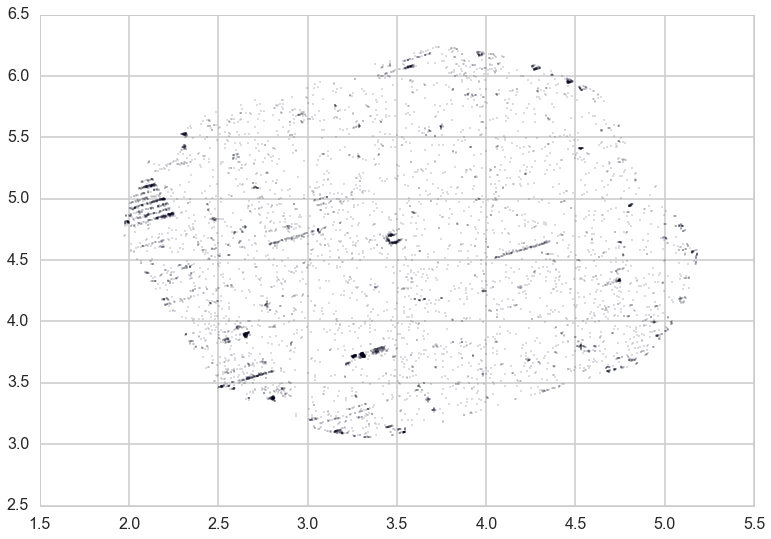

In [276]:
plt.scatter(ra_all, dec_all, s=0.1)
plt.xlim(1.5,5.5)
plt.ylim(2.5,6.5)
ra_all.shape

In [277]:
def make_colorful_plot(chip_dict, labels=True): # MJH: changed the default to drawing labels
    colors = cm.rainbow(np.linspace(0.1, 1, len(chip_dict)))
    for chip, c in zip(chip_dict, colors):
        plt.scatter(chip_dict[chip].RA_PSF, chip_dict[chip].DEC_PSF, s=0.1, label=chip, color=c)
        ram = chip_dict[chip].RA_PSF.mean()
        decm =chip_dict[chip].DEC_PSF.mean()
        if labels:
            plt.annotate(chip, xy=(ram,decm), xytext=(ram+0.1,decm-0.05), fontsize=15)
    # Note: I am inverting the x axis because that is the way it looks on the sky.
    # That is, right ascension (astro-speak for a longitude on the sky) increases to the left.
    plt.gca().invert_xaxis()
    if labels:
        plt.xlabel('RA (deg)')
        plt.ylabel('Dec (deg)')
        plt.title('Pan-STARRS-1 Gigapixel Camera')

Inverting x axis to match how the detections would look in the sky
Color-coding and labeling individual detectors within the array

z 3.572163 4.640101 55895.2093599


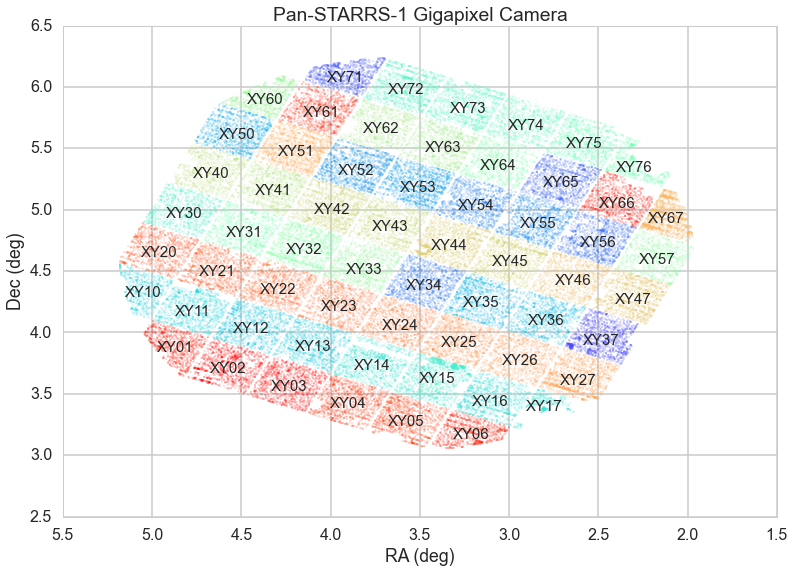

In [278]:
chip_dict, newdf = smf2pandas('test.star.smf', FLAGS_dict=FLAGS_dict, FLAGS2_dict=FLAGS2_dict)
make_colorful_plot(chip_dict)

In [279]:
newdf[newdf.mp_desig != 'None'].shape

(172, 106)

In [280]:
newdf['FLAGS'].apply(poorFlag).sum()

828

###Exploring density of detections by potential classifiers

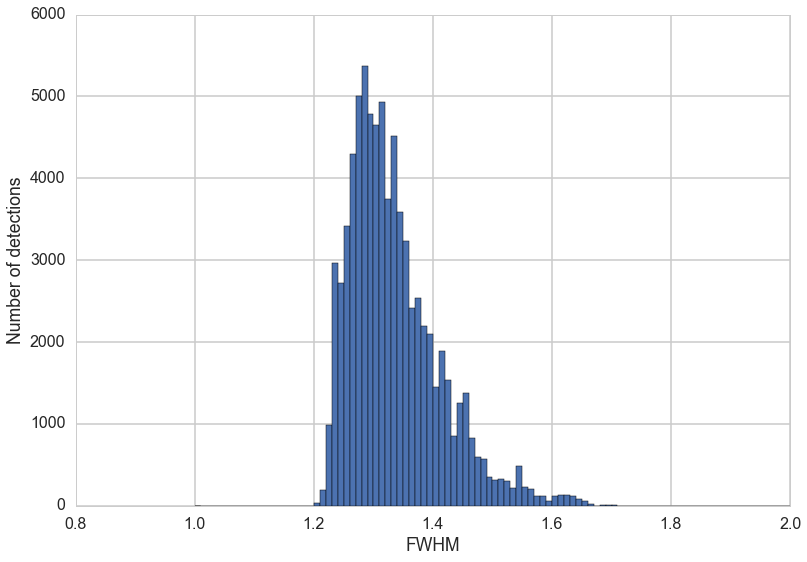

In [281]:
n, nbins, patches = plt.hist(newdf['fwhm'], bins=100, range=[1,2])
plt.xlabel("FWHM")
plt.ylabel("Number of detections")


0.997328579426


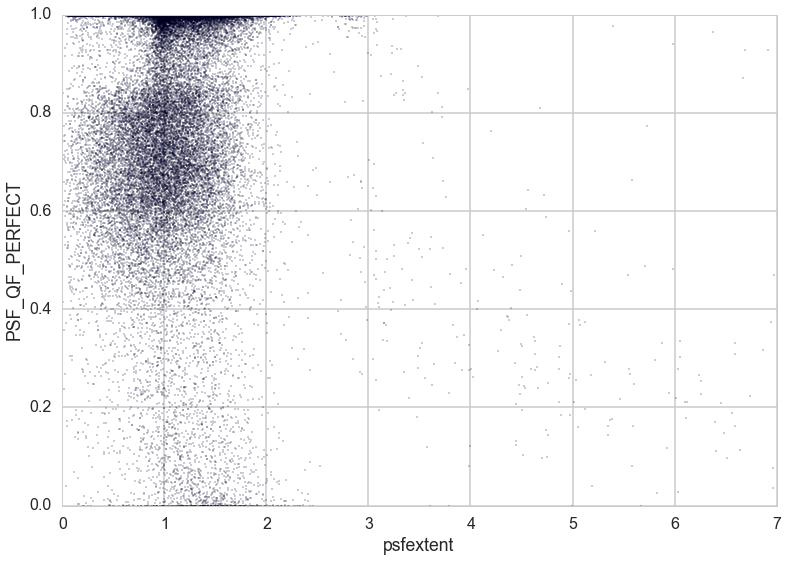

In [282]:
psfquality = newdf['PSF_QF_PERFECT']
print psfquality.median()
plt.scatter(newdf['psf_extent'], psfquality, s=0.2)
plt.xlim(0,7)
plt.ylim(0,2)
plt.xlabel("psfextent")
plt.ylabel("PSF_QF_PERFECT")
plt.ylim(0,1)
plt.show()

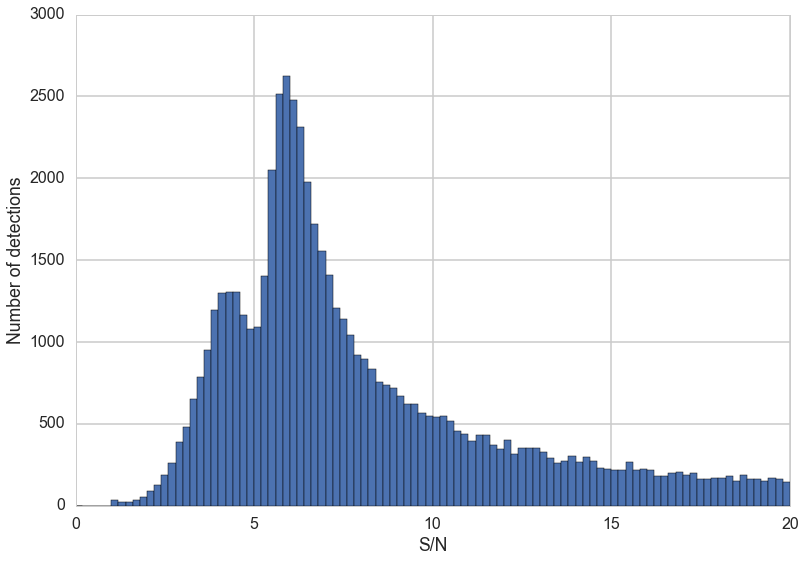

In [283]:
n, nbins, patches = plt.hist(newdf['snr'], bins=100, range=[0,20])
plt.xlabel("S/N")
plt.ylabel("Number of detections")


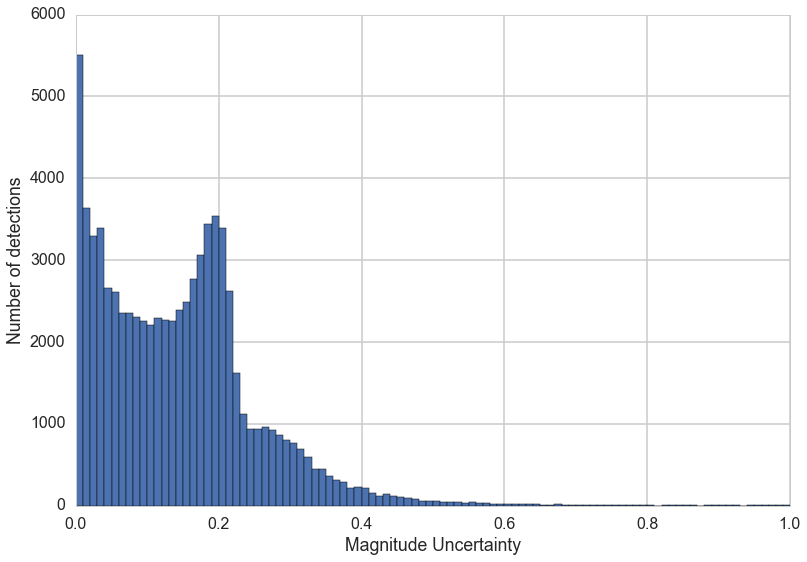

In [284]:

n, nbins, patches = plt.hist(newdf['PSF_INST_MAG_SIG'], bins=100, range=[0,1])
plt.xlabel("Magnitude Uncertainty")
plt.ylabel("Number of detections")


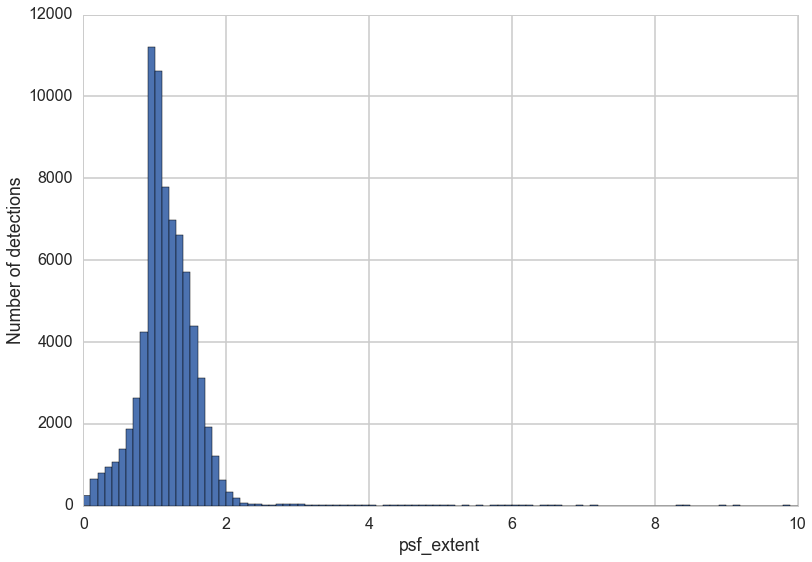

In [285]:

n, nbins, patches = plt.hist(newdf['psf_extent'], bins=100, range=[0,10])
plt.xlabel("psf_extent")
plt.ylabel("Number of detections")


The detectors in the Pan-STARRS-1 Gigapixel camera (GPC1) are prototypes, with many defects.  Each detector is a 4800x4800 Orthogonal Tranfer Array (OTA), composed of 64 cells, in an 8x8 grid.  Each 600 pixel x 600 pixel cell can be read out independently.

We see that many detections are associated with the edges of these cells.  That is evident in the two histograms below, of the x and y positions of the detections, respectively.

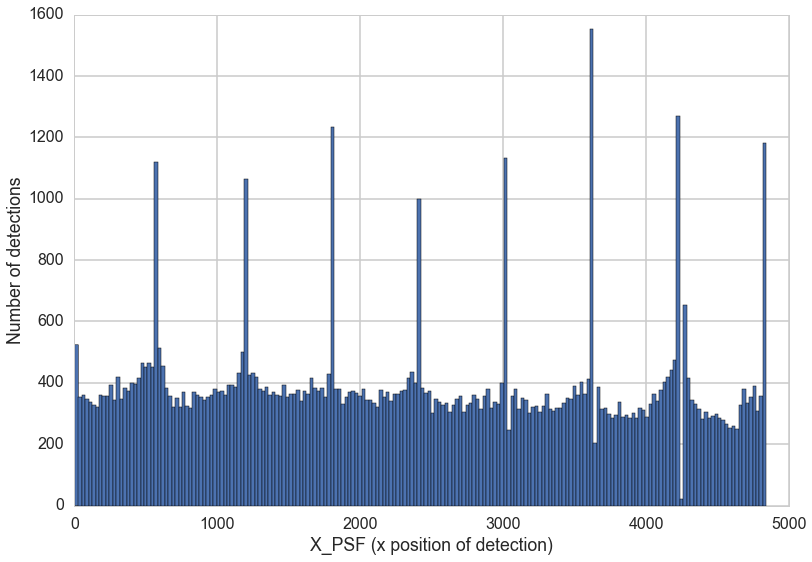

In [286]:
n, nbins, patches = plt.hist(newdf['X_PSF'], bins=200)
plt.xlabel("X_PSF (x position of detection)")
plt.ylabel("Number of detections")

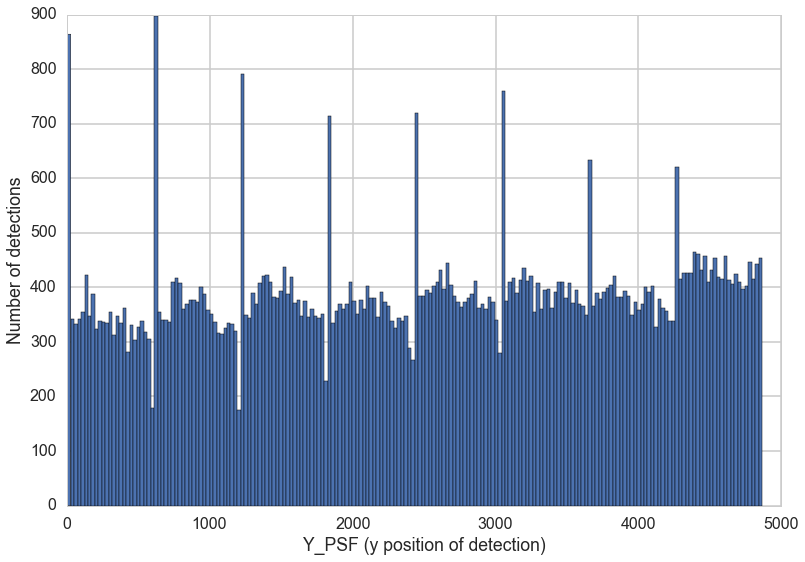

In [287]:
n, nbins, patches = plt.hist(newdf['Y_PSF'], bins=200)
plt.xlabel("Y_PSF (y position of detection)")
plt.ylabel("Number of detections")

In [288]:
newdf.head()

AP_MAG  AP_MAG_RADIUS  AP_MAG_RAW  CAL_PSF_MAG  CAL_PSF_MAG_SIG  CR_NSIGMA   DEC_PSF  EXT_NSIGMA      FLAGS  FLAGS2  IPP_IDET     KRON_FLUX  KRON_FLUX_ERR  KRON_FLUX_INNER  KRON_FLUX_OUTER  MOMENTS_M3C  MOMENTS_M3S  MOMENTS_M4C  MOMENTS_M4S  MOMENTS_R1  MOMENTS_RH  MOMENTS_XX  MOMENTS_XY  MOMENTS_YY  N_FRAMES  PADDING  PADDING2  PEAK_FLUX_AS_MAG  PLTSCALE   POSANGLE      PSF_CHISQ    PSF_INST_FLUX  PSF_INST_FLUX_SIG  PSF_INST_MAG  PSF_INST_MAG_SIG  PSF_MAJOR  PSF_MINOR  PSF_NDOF  \
0 -15.724316             11  -15.649606     9.562006           0.0002        NaN  3.952620   42.940945  640680069     128         0          -inf            NaN    3023516.25000   1862353.000000    14.618450     4.760791     1.416535     0.608149         NaN    1.963364   39.411476   -4.489249   29.150957         0        0         0        -11.425479  0.255873 -44.950493  997430.562500  26142684.000000       15258.401367    -18.543377          0.000584   2.364025   2.205285     21047   
1 -15.391106             11  -15.316396    15.057261           0.0002        NaN  3.864354  117.107620  103825415     160         1  1.337260e+06    1537.431396     341410.12500      1004.133301    -0.090274    -0.881527     0.350518    -0.037179    2.947113    1.234334    1.889432    0.134548    4.833177         0        0         0        -11.419569  0.255641 -44.923401  706189.250000    165671.843750         616.485168    -13.048121          0.003721   2.289338   2.232472      4086   
2 -14.712990             11  -14.638280    17.368683           0.0002        NaN  3.951783  159.373016  572522625       0         2           NaN            NaN     185575.15625    344422.281250    -0.135545     0.127662     0.154432     0.322281         NaN    0.557751    0.676340   -0.275254    2.873093         0        0         0        -11.416001  0.255869 -44.949932  938866.187500     19709.681641         302.497314    -10.736699          0.015348   2.363841   2.205340      4554   
3 -15.462722             11  -15.388012    12.681553           0.0002        NaN  3.799670    5.422551  103825415     128         3  1.403954e+06    1430.927002     338617.31250     88140.257812     0.153482    -0.495743     0.091551     0.015648    3.820368    1.893336    7.592988    0.083297    7.193233         0        0         0        -11.366590  0.255410 -44.925587   72203.671875   1477515.500000        1468.015991    -15.423830          0.000994   2.446745   2.155717      4086   
4 -15.429978             11  -15.355268    12.697256           0.0002        NaN  4.023787    1.708120  639631493     128         4          -inf            NaN     476266.78125    106980.093750     0.096281    -0.202389     0.100890     0.014142         NaN    1.694928    2.669092    0.011892    2.764178         0        0         0        -11.332457  0.255411 -44.995491  132031.093750   1456299.875000        1458.792114    -15.408127          0.001002   2.399178   2.234610      5773   

   PSF_NPIX    PSF_QF  PSF_QF_PERFECT  PSF_THETA    RA_PSF         SKY  SKY_SIGMA        X_PSF  X_PSF_SIG        Y_PSF  Y_PSF_SIG  mp_dec_rate mp_desig  mp_mag  mp_prox  mp_ra_rate  on_star  chip filterID        mag          snr      fwhm  psf_extent BIG_RADIUS MOMENTS_FAILURE EXT_LIMIT EXTERNALPOS DEFAULT NONLINEAR_FIT DEFECT SKY_FAILURE LINEAR_FIT RADIAL_FLUX PSFSTAR POORFIT SKYVAR_FAILURE   PAIR OFF_CHIP  BLEND FITFAIL MOMENTS_SN SATURATED BLEND_FIT AP_MAGS SIZE_SKIPPED CR_LIMIT ON_SPIKE  \
0     21050  0.107734        0.075528 -25.710072  2.609610  151.263809  14.220932  3430.437744   0.001527  4232.690430   0.003072          NaN     None     NaN      NaN         NaN        1  XY37        z   9.562006  1860.724922  1.375740   14.844969       True           False     False       False   False          True  False       False       True       False   False   False          False  False    False  False   False      False     False     False    True        False    False    False   
1      4087  0.998310        0.422473  82.875938 

Now I would like to add some more columns to the dataframe.  These are indicators of various characteristics of the detections.

In [289]:
# MJH: this section of code is repeated after every call to smf2pandas.  We probably should
# consolidate it into its own function.  This was used for EDA; perhaps we won't need it later.

def generate_masks(df, snr_thresh=5.0, qfp_thresh=0.4):
    
    # Calculate masks based on threshold values and quantifies in df.
    flag_mask = df['FLAGS'].apply(flagOK)
    poor_mask = df['FLAGS'].apply(poorFlag)
    snr_mask =  df['snr'].apply(lambda x: x >= snr_thresh)
    inBox_mask = np.array(map(lambda (x, y): inBox(x, y), zip(df['X_PSF'], df['Y_PSF'])))
    magOK_mask = np.array(map(lambda (x, y): magOK(x, y), zip(df['mag'], df['PSF_INST_MAG_SIG'])))
    qfp_mask   = df['PSF_QF_PERFECT'].apply(lambda x: x >= qfp_thresh)
    offStar_mask =  df['on_star']==0
    
    # Add some columns to df.
    df['flagsOK'] = pd.Series(flag_mask,  index=df.index)
    df['in_box']  = pd.Series(inBox_mask, index=df.index)
    df['magOK']   = pd.Series(magOK_mask, index=df.index)
    df['qfpOK']   = pd.Series(qfp_mask,   index=df.index)

    return df, flag_mask, snr_mask, inBox_mask, magOK_mask, qfp_mask, offStar_mask, poor_mask


In [290]:
newdf, flag_mask, snr_mask, inBox_mask, magOK_mask, qfp_mask, offStar_mask, poor_mask = \
    generate_masks(newdf)

# good_mask refers to detections that pass all the various checks
good_mask = flag_mask & snr_mask & inBox_mask & magOK_mask & qfp_mask

# remainder_mask refers to detections that pass all the tests and which are not on a star.
remainder_mask = good_mask & offStar_mask


Use good_mask, defined in previous section, to visualize potential bad areas of the detectors:

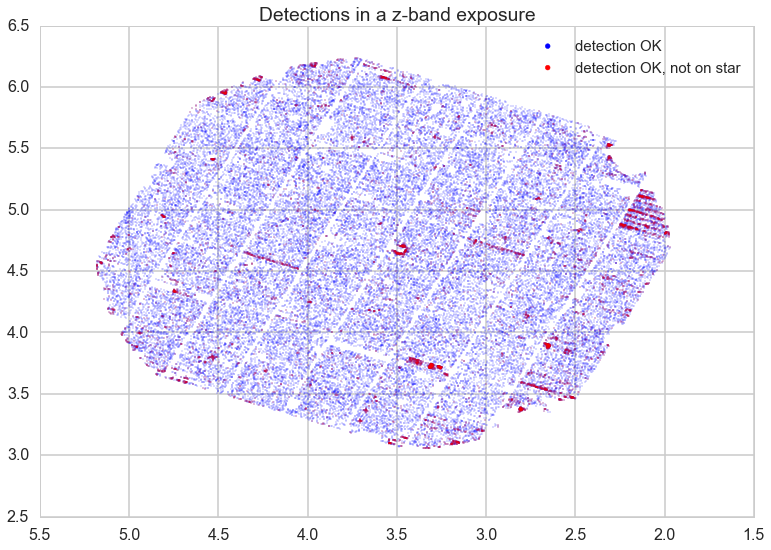

In [291]:
s1 = plt.scatter(newdf[good_mask].RA_PSF, newdf[good_mask].DEC_PSF, s=0.1, color='blue', label='detection OK')
s2 = plt.scatter(newdf[remainder_mask].RA_PSF, newdf[remainder_mask].DEC_PSF, s=0.1, color='red', label='detection OK, not on star')
plt.title('Detections in a z-band exposure')
leg = plt.legend(markerscale=15, fontsize=15)
plt.gca().invert_xaxis()

What I see in the plot above, aside from the expected roughly uniform distribution of astrophysical sources, are some linear groups of detections and some clumps of detections.  

The linear groups are probably the same kind of detections along the edges of cells that we've seen before.  Perhaps there is a bug in the inBox_mask or perhaps the region that should be removed varies from detector to detector.

The clumps of detections are either real, extended groups of stars such as globular clusters, or they are clumps of false detections around a saturated bright star or around a large detector defect.

It is hard to determine visually how many of the false positives are in these linear or clumped features, but it could be a significant fraction of the total (half).


In [292]:
newdf[newdf.chip=='XY76'].shape

(766, 110)

Using fold function, plot detections based on potential good/bad classification based on location within detector.  Note the concentration of bad detections along borders of detection.  Adjusting "inbox" parameters results in good detections being distributed within an area bordered by the bad detections.

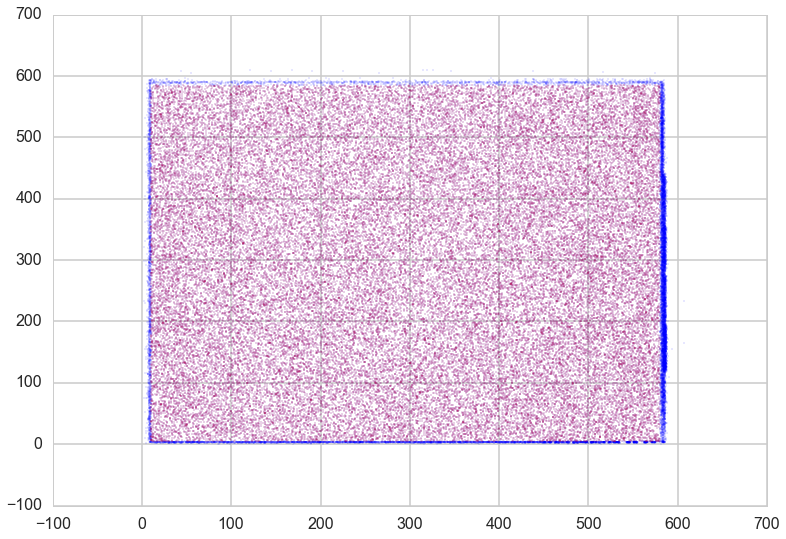

In [293]:
plt.scatter(xfold(newdf['X_PSF']), yfold(newdf['Y_PSF']), s=0.05, color='blue')
plt.scatter(xfold(newdf['X_PSF'][inBox_mask]), yfold(newdf['Y_PSF'][inBox_mask]), s=0.05, color='red')

# It can be that there are lines of false detections in individual detections that do not show
# up in this plot because they are obscured by the other detections.


Here's an example for a particularly bad detector, without folding:

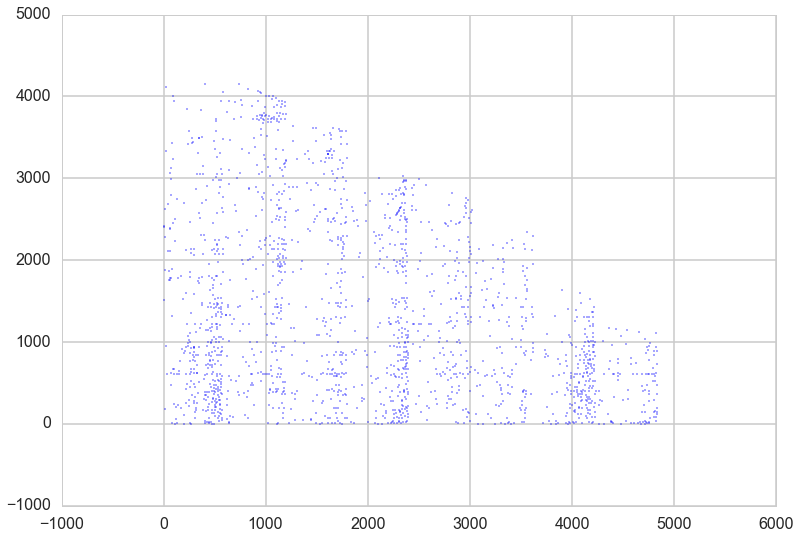

In [294]:
# Need to make this plot from many examples from the same chip, essentially to map out the
# the defect mask for each chip, not just those features that are common to all chips.
plt.scatter(chip_dict['XY67']['X_PSF'], chip_dict['XY67']['Y_PSF'], s=0.5, color='blue')


The "badFlags" mask that I used above is supposed to eliminate 20-25% of the false detections, according to Metcalfe et al. (2013) [MNRAS 435, 1825–1839 (2013)] and Magnier et al. (2013) [].

If I take 2148 as 20% of the false detections the fraction of the total is 10740.

So, what are some things that remain to be done?

1. We can tune the SNR threshhold.
2. We can tune the PSF_QF_PERFECT threshhold.
3. We can tune the detector edge cuts.
4. We can use stacks of smf files to map out false positive regions of each detector.
5. We can look at the 'poor' masks to see if any of those fields are important.
6. I need to identify the known moving objects in the field.
7. I could use a bright star catalog (with proper motions incorporated) to locate the bright stars in the exposure in order to mask out bigger regions.

In [295]:
2148/0.2

10740.0

In [296]:
det_eff_tup = det_eff_dict['XY02']
count_max = det_eff_tup[1]
offs = np.array(map(lambda v: v[0], det_eff_tup[2]), dtype=np.float64)
fluxes = np.power(10.0,-0.4*offs)
counts = np.array(map(lambda v: float(v[1]), det_eff_tup[2]), dtype=np.float64)
mean_errs = np.array(map(lambda v: v[4], det_eff_tup[2]), dtype=np.float64)
fracs = counts/count_max


[ 0.78124728  0.06668515  0.33321289]


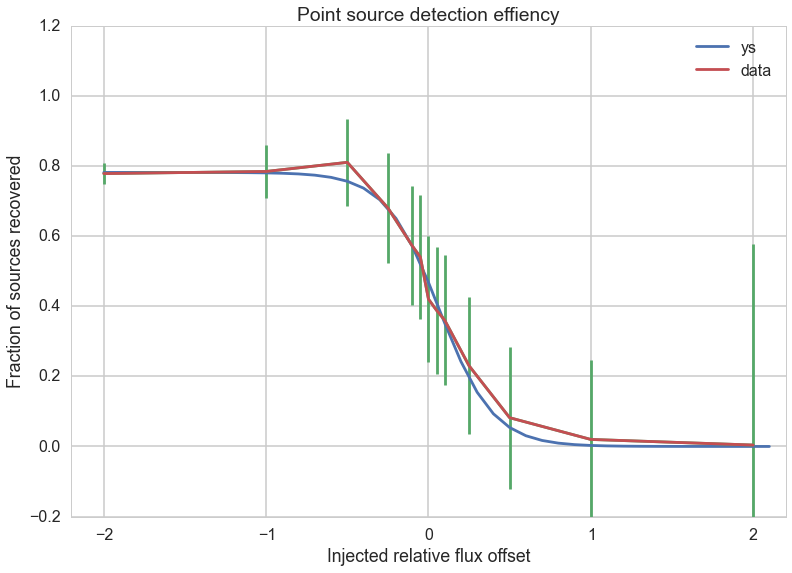

In [297]:
# MJH: we haven't yet made use of the detection efficiency information.  Perhaps for later work.
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*0.5*(1.0-np.tanh((x-b)/c))

def func2(x, a, b, c):
    return a*0.5*(1.0-sp.special.erf((x-b)/c))

popt, pv = curve_fit(func, offs, fracs, p0=[0.3, 0.05, 0.3], sigma=mean_errs)
print popt

#popt2, pv = curve_fit(func2, offs, fracs, p0=[0.3, 0.05, 0.3], sigma=mean_errs)
#print popt2
xs = np.arange(-2,2.2,0.1)
ys = func(xs, popt[0], popt[1], popt[2])
#ys2 = func(xs, popt2[0], popt2[1], popt2[2])

plt.plot(xs,ys, label='ys')
#plt.plot(xs,ys2, label='ys2')
plt.errorbar(offs, fracs, yerr=mean_errs)
plt.plot(offs, fracs, label='data')
plt.ylim(-0.2,1.2)
plt.xlim(-2.2, 2.2)
plt.xlabel("Injected relative flux offset")
plt.ylabel("Fraction of sources recovered")
plt.title("Point source detection effiency")
plt.legend()

In [298]:
(2148/0.2)/77825

0.1380019274012207

The question is how many of the remainig 80% of the false detections we can remove.

y 5.754165 6.050334 55895.1872537


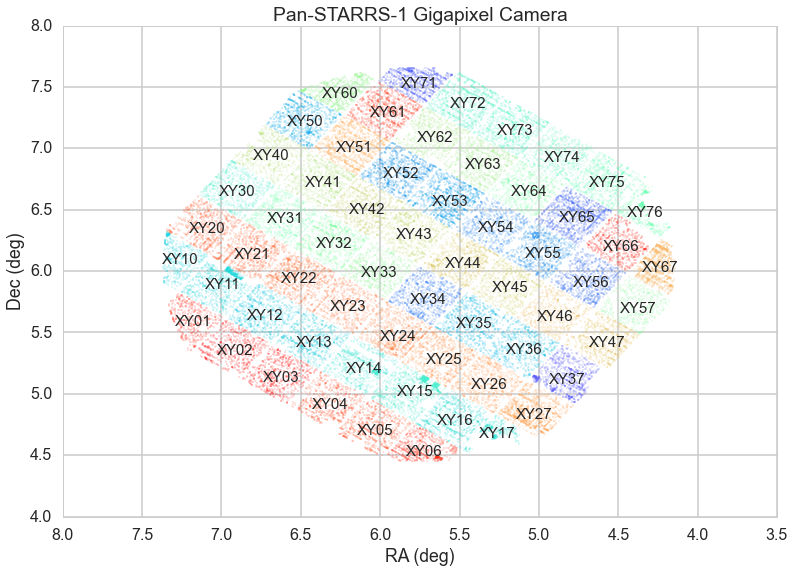

In [299]:
chip_dict, newdf = smf2pandas('data/o5895g0004o.424868.cm.333484.n.smf',FLAGS_dict=FLAGS_dict, FLAGS2_dict=FLAGS2_dict)
make_colorful_plot(chip_dict)

In [300]:
newdf, flag_mask, snr_mask, inBox_mask, magOK_mask, qfp_mask, offStar_mask, poor_mask = \
    generate_masks(newdf)

# good_mask refers to detections that pass all the various checks
good_mask = flag_mask & snr_mask & inBox_mask & magOK_mask & qfp_mask

# remainder_mask refers to detections that pass all the tests and which are not on a star.
remainder_mask = good_mask & offStar_mask


Similar to above plot, but showing detections made with a y-band filter

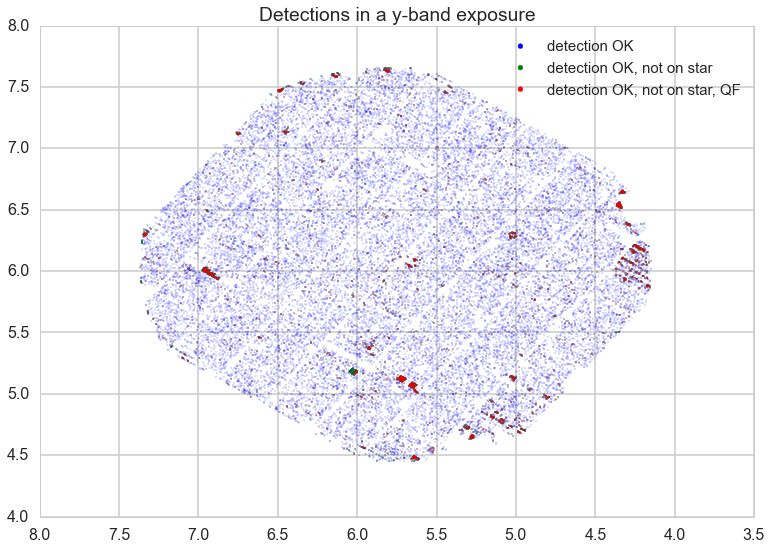

In [301]:
s1 = plt.scatter(newdf[good_mask].RA_PSF, newdf[good_mask].DEC_PSF, s=0.1, color='blue', label='detection OK')
s2 = plt.scatter(newdf[remainder_mask].RA_PSF, newdf[remainder_mask].DEC_PSF, s=0.1, color='green', label='detection OK, not on star')
s3 = plt.scatter(newdf[remainder_mask & (newdf.PSF_QF_PERFECT>=0.99)].RA_PSF, newdf[remainder_mask & (newdf.PSF_QF_PERFECT>=0.99)].DEC_PSF, s=0.1, color='red', label='detection OK, not on star, QF')

plt.title('Detections in a y-band exposure')
leg = plt.legend(markerscale=15, fontsize=15)
plt.gca().invert_xaxis()

In [302]:
print (remainder_mask & (newdf.PSF_QF_PERFECT>=0.85)).sum()
print (remainder_mask).sum()


4388
4805


y 5.961855 3.216078 55895.1877649


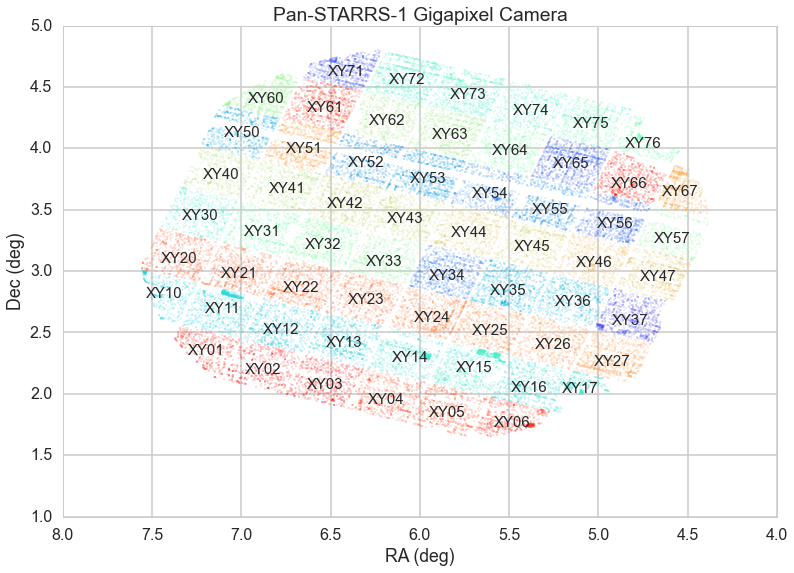

In [303]:
chip_dict, newdict = smf2pandas('data/o5895g0005o.424869.cm.333488.n.smf',FLAGS_dict=FLAGS_dict, FLAGS2_dict=FLAGS2_dict)
make_colorful_plot(chip_dict)

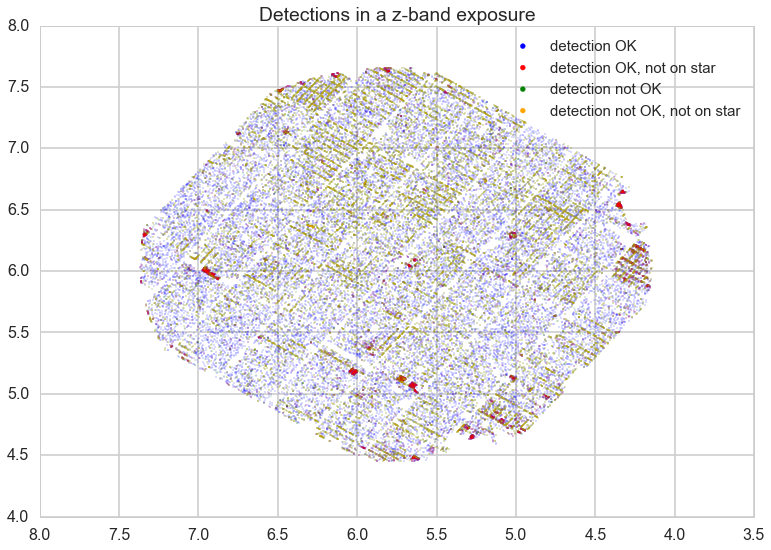

In [304]:
s1 = plt.scatter(newdf[good_mask].RA_PSF, newdf[good_mask].DEC_PSF, s=0.1, color='blue', label='detection OK')
s2 = plt.scatter(newdf[remainder_mask].RA_PSF, newdf[remainder_mask].DEC_PSF, s=0.1, color='red', label='detection OK, not on star')
s3 = plt.scatter(newdf[~good_mask].RA_PSF, newdf[~good_mask].DEC_PSF, s=0.1, color='green', label='detection not OK')
s4 = plt.scatter(newdf[~good_mask & offStar_mask].RA_PSF, newdf[~good_mask & offStar_mask].DEC_PSF, s=0.1, color='orange', label='detection not OK, not on star')

plt.title('Detections in a z-band exposure')
leg = plt.legend(markerscale=15, fontsize=15)
plt.gca().invert_xaxis()

What fraction of the detections that are "on-star" also have the flags and other characteristics of detections that we think are likely false positives?  From that number we can estimate the fraction of real moving sources that we might classify as false (aside from any additional issues with trailing).

How can we stack the files of remaining detections to better identify the per-chip regions that generate false positives?  

In [305]:
float(remainder_mask.sum())/remainder_mask.shape[0]

0.0983502538071066

In [306]:
float((~good_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.061151614343103705

At least in this case, about 6% of the detections that coincide with stars are also flagged as likely false positives.  

We can break this down further.

In [307]:
float((~flag_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.017073352179735157

About 2% of the "on-star" detections also have bad flags.  Some of those are bright, known stars that are saturated.  Those are not moving objects; it's ok to exclude them.

In [308]:
float((~snr_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.011382234786490105

About 1% of the "on-star" detections are below the S/N cut.  These are likely objects that were detected at higher S/N in other, more sensitive bands.

In [309]:
float((~inBox_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.039093884838565691

About 4% of the "on-star" detections are along the edges.  This seems low, based on the ~8% of detector area that is eliminated (30 pixels out of 600 in the x direction and 20 pixels out of 600 in the y direction).  I will double check this, but it could mean that stars are less detectable on the edges as well.  That seems plausible, if the edge regions are less sensitive.

In [310]:
float((~qfp_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.014767147745871151

Fewer than 2% of the "on-star" detections do not satisfy the PSF_QF_PERFECT cut.

In [311]:
float((~magOK_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.0040916530278232409

An very small fraction of the "on-star" detections have a NaN or Inf for their magnitudes or magnitude uncertainties.

What about other flags and characteristics?

In [312]:
float((poor_mask & ~offStar_mask).sum())/(~offStar_mask).sum()

0.0014134801368843922

In [313]:
float((poor_mask & offStar_mask).sum())/(offStar_mask).sum()

0.0024121609320953939

Very few of the detections, either "on-star" or off, have any of the poor mask flags set.

In [314]:
#float((~good_mask & ~offStar_mask).sum())/(~offStar_mask).sum()
float((good_mask & (newdf.mp_desig != 'None')).sum())/(newdf.mp_desig != 'None').sum()

0.95890410958904104

In [315]:
# These are the asteroid detections that had a bad flag.
newdf[~good_mask & (newdf.mp_desig != 'None')]

AP_MAG  AP_MAG_RADIUS  AP_MAG_RAW  CAL_PSF_MAG  CAL_PSF_MAG_SIG  CR_NSIGMA   DEC_PSF  EXT_NSIGMA     FLAGS  FLAGS2  IPP_IDET   KRON_FLUX  KRON_FLUX_ERR  KRON_FLUX_INNER  KRON_FLUX_OUTER  MOMENTS_M3C  MOMENTS_M3S  MOMENTS_M4C  MOMENTS_M4S  MOMENTS_R1  MOMENTS_RH  MOMENTS_XX  MOMENTS_XY  MOMENTS_YY  N_FRAMES  PADDING  PADDING2  PEAK_FLUX_AS_MAG  PLTSCALE    POSANGLE    PSF_CHISQ  PSF_INST_FLUX  PSF_INST_FLUX_SIG  PSF_INST_MAG  PSF_INST_MAG_SIG  PSF_MAJOR  PSF_MINOR  PSF_NDOF  PSF_NPIX  \
8854  -6.077059              9   -5.984974    20.569780         0.015625        NaN  7.077491   -2.184605  35651585       0       398  179.231354     146.853210       -66.435150       200.424942    -2.762279    -0.118012    -0.877804     0.874754    2.570158    1.273339    0.693455   -0.199901    1.402294         0        0         0         -4.326085  0.255767  135.114914  1484.785522     415.490479         144.241272     -6.546402          0.347159   2.266585   1.870543      1308      1309   
10451 -7.508618              8   -7.398751    19.476772         0.015625        NaN  5.424146   -0.990148  35653633       0       393  807.289001     170.655869       162.489944        -3.891174     0.468148     0.041055     0.072014     0.006573    2.299248    1.559269    0.991593   -0.595845    1.477076         0        0         0         -4.409597  0.256370  -44.980930  1697.119751    1137.008545         128.155182     -7.639409          0.112713   2.158670   1.612744      1630      1631   
33539 -6.653100              9   -6.561648    19.783669         0.015625        NaN  5.422342   -0.596445  35651585       0       369  684.779785     141.850037       332.469086        -4.415924     0.946865    -0.806119     0.315249     0.296243    2.511304    1.210113    2.513843   -0.074639    0.990440         0        0         0         -4.365182  0.255698  134.966965  1664.202271     857.049255         135.885315     -7.332514          0.158550   2.381335   1.711413      1523      1524   

         PSF_QF  PSF_QF_PERFECT  PSF_THETA    RA_PSF         SKY  SKY_SIGMA        X_PSF  X_PSF_SIG        Y_PSF  Y_PSF_SIG  mp_dec_rate mp_desig  mp_mag   mp_prox  mp_ra_rate  on_star  chip filterID        mag        snr      fwhm  psf_extent BIG_RADIUS MOMENTS_FAILURE EXT_LIMIT EXTERNALPOS DEFAULT NONLINEAR_FIT DEFECT SKY_FAILURE LINEAR_FIT RADIAL_FLUX PSFSTAR POORFIT SKYVAR_FAILURE   PAIR OFF_CHIP  BLEND FITFAIL MOMENTS_SN SATURATED BLEND_FIT AP_MAGS SIZE_SKIPPED CR_LIMIT ON_SPIKE BADPSF  \
8854   0.656503        0.656503   9.078724  6.386470  273.356964  16.859529  1451.897339   0.738636  4860.485840   0.738636    -0.113480    G0078  20.538  0.604497    0.151114        0  XY50        y  20.569780   3.654089  1.240135    0.478915      False           False     False       False   False         False  False       False       True       False   False   False          False  False    False  False   False      False     False     False    True        False    False    False  False   
10451  0.945965        0.945965 -84.226677  5.108486  280.031708  17.123562  1792.697144   0.239814  2842.939453   0.239814     0.012084    78457  19.481  0.117321    0.174724        0  XY36        y  19.476772  10.141435  1.126412    0.648623      False           False     False       False   False         False   True       False       True       False   False   False          False  False    False  False   False      False     False     False    True        False    False    False  False   
33539  0.814379        0.814379 -27.462524  4.673165  275.390961  16.725546  1641.993286   0.337341  1834.178467   0.337341    -0.165949    42961  19.942  0.196469    0.188083        0  XY47        y  19.783669   7.360068  1.215540    0.781619      False           False     False       False   False         False  False       False       True       False   False   False          False  False    False  False   False      False     False     False    True        False    False    False  False   

      EXTEN

Applying the good_mask eliminates the spikes along the edges of the detectors

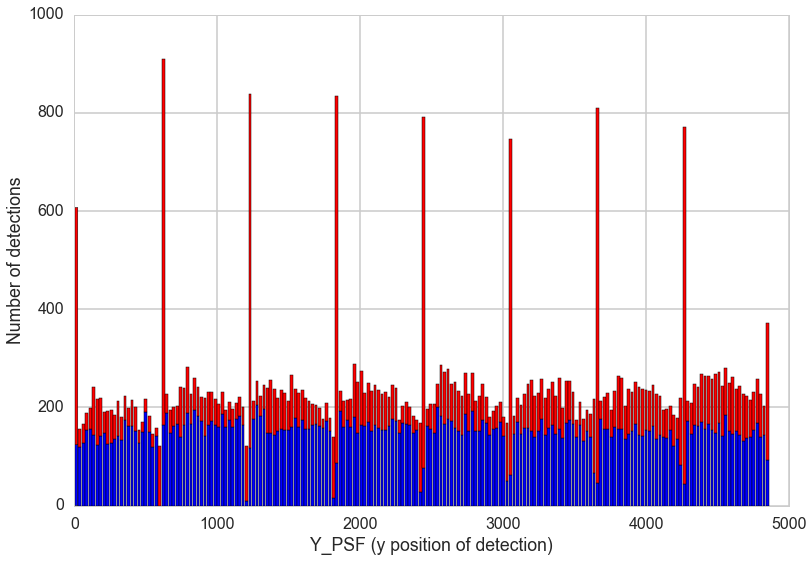

In [316]:
y0 = newdf[good_mask].Y_PSF.values
y1 = newdf[~good_mask].Y_PSF.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([y0, y1], bins=200, color=colors, label=labels, stacked=True)

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("Y_PSF (y position of detection)")
plt.ylabel("Number of detections")

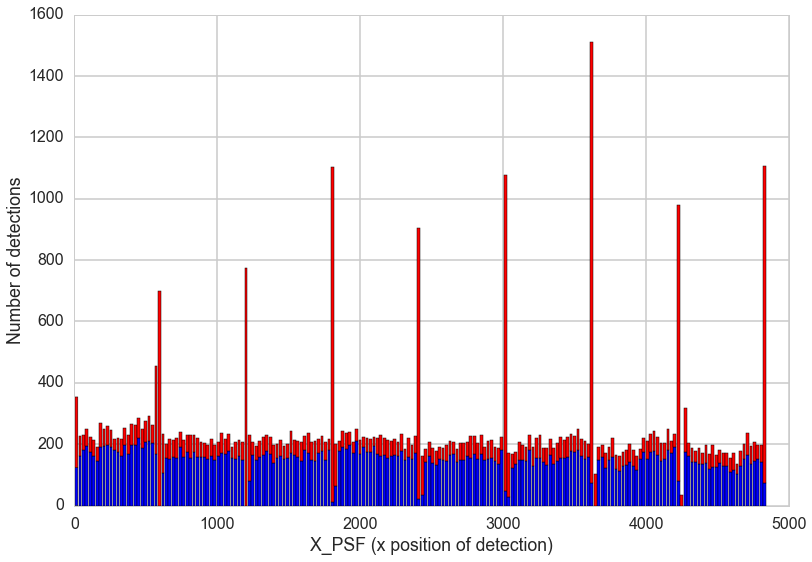

In [317]:
x0 = newdf[good_mask].X_PSF.values
x1 = newdf[~good_mask].X_PSF.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([x0, x1], bins=200, color=colors, label=labels, stacked=True)

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("X_PSF (x position of detection)")
plt.ylabel("Number of detections")

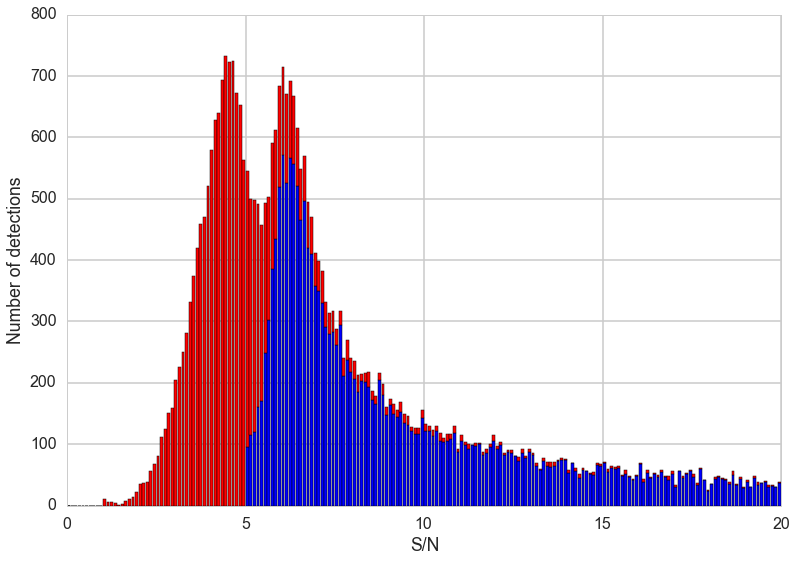

In [318]:
s0 = newdf[good_mask].snr.values
s1 = newdf[~good_mask].snr.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=200, color=colors, label=labels, stacked=True, range=[0,20])

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("S/N")
plt.ylabel("Number of detections")

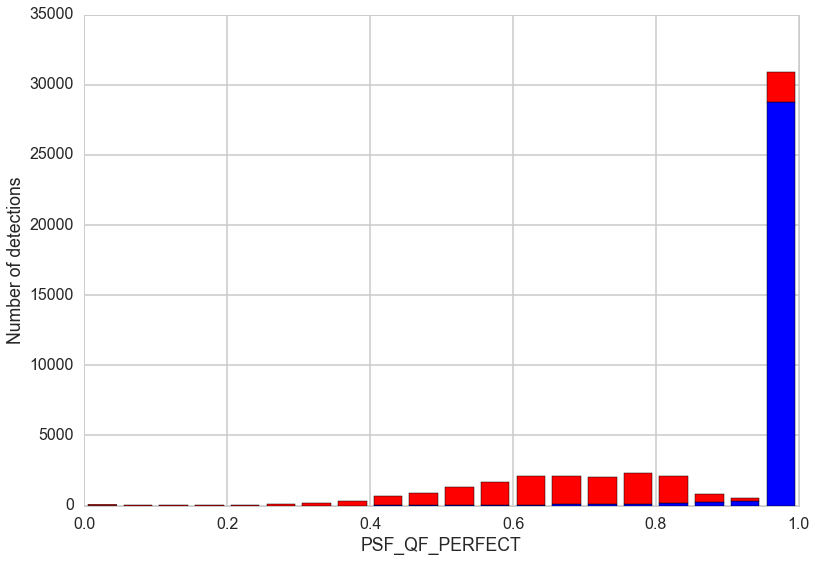

In [319]:
s0 = newdf[good_mask].PSF_QF_PERFECT.values
s1 = newdf[~good_mask].PSF_QF_PERFECT.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=20, color=colors, label=labels, stacked=True, range=[0,1])

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("PSF_QF_PERFECT")
plt.ylabel("Number of detections")

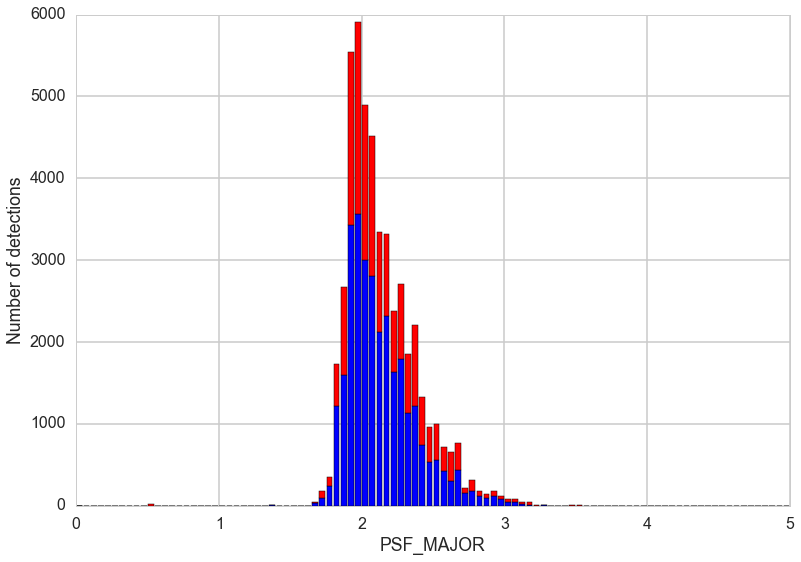

In [320]:
s0 = newdf[good_mask].PSF_MAJOR.values
s1 = newdf[~good_mask].PSF_MAJOR.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=100, color=colors, label=labels, stacked=True, range=[0,5])

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("PSF_MAJOR")
plt.ylabel("Number of detections")

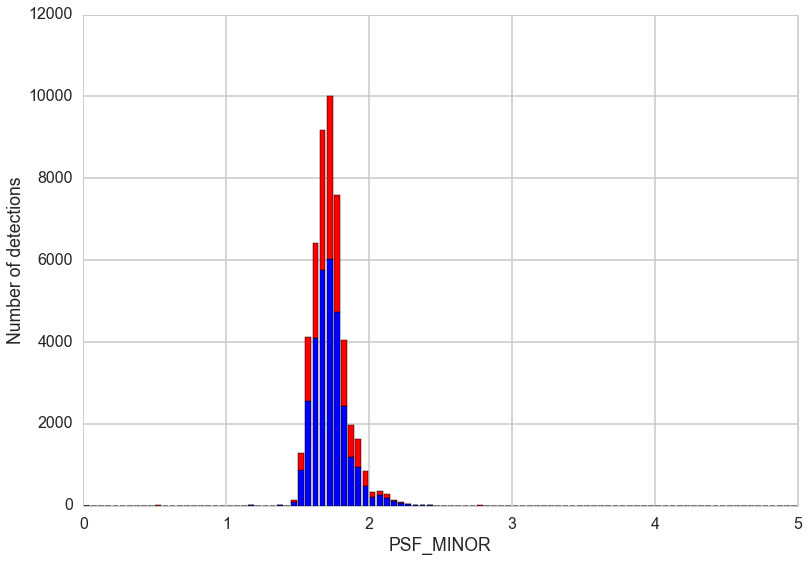

In [321]:
s0 = newdf[good_mask].PSF_MINOR.values
s1 = newdf[~good_mask].PSF_MINOR.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=100, color=colors, label=labels, stacked=True, range=[0,5])

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("PSF_MINOR")
plt.ylabel("Number of detections")

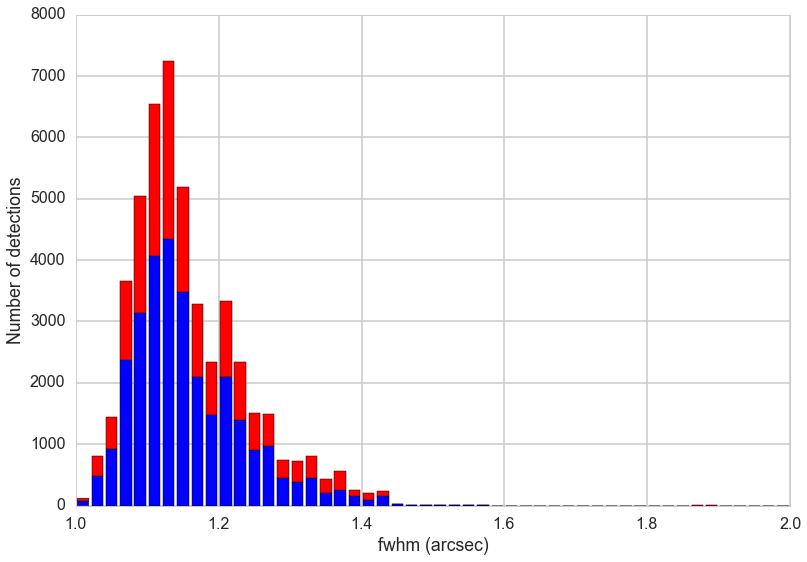

In [322]:
s0 = newdf[good_mask].fwhm.values
s1 = newdf[~good_mask].fwhm.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=50, color=colors, label=labels, stacked=True, range=[1,2])

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("fwhm (arcsec)")
plt.ylabel("Number of detections")

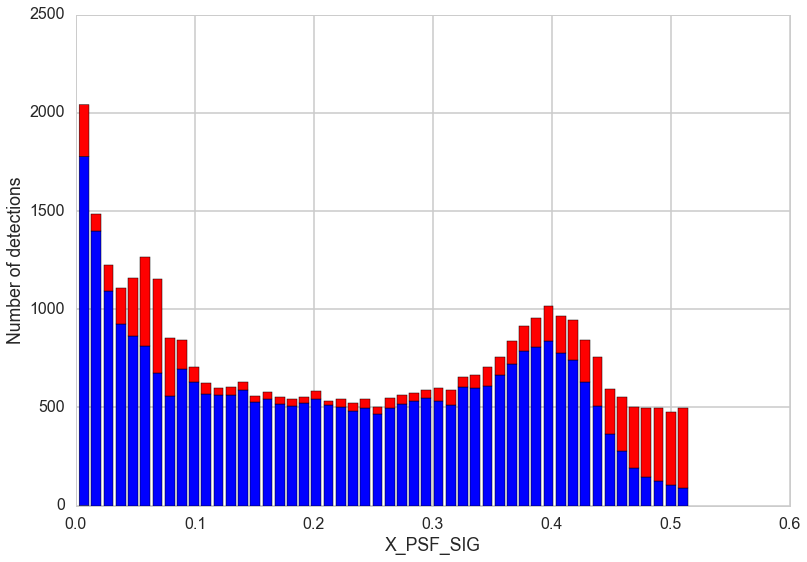

In [323]:
s0 = newdf[good_mask].X_PSF_SIG.values
s1 = newdf[~good_mask].X_PSF_SIG.values
colors = ['blue', 'red']
labels = ['good', 'not good']
n, nbins, patches = plt.hist([s0, s1], bins=50, color=colors, label=labels, stacked=True)

#n, nbins, patches = plt.hist(newdf[good_mask].Y_PSF, bins=200)
plt.xlabel("X_PSF_SIG")
plt.ylabel("Number of detections")

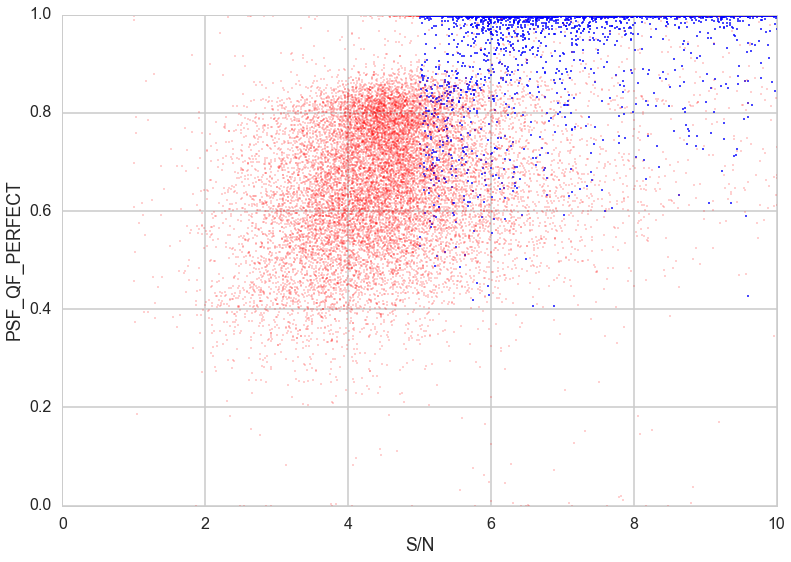

In [324]:
x0 = newdf[good_mask].snr.values
s0 = newdf[good_mask].PSF_QF_PERFECT.values
x1 = newdf[~good_mask].snr.values
s1 = newdf[~good_mask].PSF_QF_PERFECT.values
x2 = newdf[inBox_mask].snr.values
s2 = newdf[inBox_mask].PSF_QF_PERFECT.values
x3 = newdf[flag_mask].snr.values
s3 = newdf[flag_mask].PSF_QF_PERFECT.values
x4 = newdf[magOK_mask].snr.values
s4 = newdf[magOK_mask].PSF_QF_PERFECT.values

#plt.scatter(x3, s3, color='green', label='flags good', s=0.5, alpha=0.5)
#plt.scatter(x2, s2, color='green', label='inBox', s=2.0, alpha=1.0)
plt.scatter(x0, s0, color='blue', label='good', s=2.0, alpha=1.0)
plt.scatter(x1, s1, color='red', label='not good', s=0.5, alpha=0.5)
#plt.scatter(x4, s4, color='green', label='flags good', s=0.5, alpha=0.5)
plt.xlim(0,10)
plt.xlabel("S/N")
plt.ylabel("PSF_QF_PERFECT")
plt.ylim(0,1)
plt.show()

set up "on_match" classifier to combine both star and minor planet matches

In [325]:
# Added to replace onmatch function from C.A.
# MJH: Not sure what we want to do here
#newdf['on_match'] = (newdf.on_star | (newdf.mp_desig != 'None')) & ~newdf.on_faulty
newdf['on_match'] = (newdf.on_star | (newdf.mp_desig != 'None'))

The "edges" classifier was used to mask out all outer detectors, but this was found to be overkill

In [326]:
# Added, moved it up from below to incorporate into on_match
# edges = ['XY01','XY02','XY03','XY04','XY05','XY06',
#          'XY10','XY20','XY30','XY40','XY50','XY60',
#          'XY17','XY27','XY37','XY47','XY57','XY67',
#          'XY71','XY72','XY73','XY74','XY75','XY76']
edges = ['XY67'] #this detector has the most known bad sensors

newdf['on_faulty'] = newdf['chip'].isin(edges)

For EDA, separate potential classifiers into "indicators" vs "continuous features" groups

In [327]:
# Separate potential classifiers into groups
lcols=list(newdf.columns)

# list of possible indicator features
INDICATORS = ['in_box', 'flagsOK', 'BIG_RADIUS','MOMENTS_FAILURE','EXT_LIMIT','EXTERNALPOS','DEFAULT','NONLINEAR_FIT','DEFECT',
              'SKY_FAILURE','LINEAR_FIT','RADIAL_FLUX','PSFSTAR','POORFIT','SKYVAR_FAILURE','PAIR','OFF_CHIP','BLEND',
              'FITFAIL','MOMENTS_SN','SATURATED','BLEND_FIT','AP_MAGS','SIZE_SKIPPED','CR_LIMIT','ON_SPIKE','BADPSF',
              'EXTENDED_FIT','UNDEFINED','EXTENDED_STATS','SATSTAR','FITTED','EXTMODEL','ON_GHOST','PSFMODEL',
              'HAS_BRIGHTER_NEIGHBOR','ON_STARCORE','ON_CONVPOOR','PASS1_SRC','DIFF_SELF_MATCH','BRIGHT_NEIGHBOR_1',
              'SATSTAR_PROFILE','ON_BURNTOOL','BRIGHT_NEIGHBOR_10','DIFF_WITH_DOUBLE','DIFF_WITH_SINGLE'
             ]

# list of possible continuous features
ccols = ['AP_MAG','AP_MAG_RADIUS','AP_MAG_RAW','CAL_PSF_MAG','CAL_PSF_MAG_SIG','DEC_PSF','EXT_NSIGMA','PEAK_FLUX_AS_MAG',
         'PLTSCALE','POSANGLE','PSF_CHISQ','PSF_INST_FLUX','PSF_INST_FLUX_SIG','PSF_INST_MAG','PSF_INST_MAG_SIG',
         'PSF_MAJOR','PSF_MINOR','PSF_NDOF','PSF_NPIX','PSF_QF','PSF_QF_PERFECT','PSF_THETA','RA_PSF','SKY',
         'SKY_SIGMA','X_PSF','X_PSF_SIG','Y_PSF','Y_PSF_SIG','mag','snr','fwhm','psf_extent'
        ]

# anything which isn't in INDICATORS or ccols will be added to 'other'
other = []

# list of all features under consideration
testfeatures = []
for i in INDICATORS:
    testfeatures.append(i)
for c in ccols:
    testfeatures.append(c)   
for c in lcols:
    if c not in testfeatures:
        other.append(c)

print 'potential continuous predictors:',len(ccols)
print 'potential indicators:',len(INDICATORS)
print 'other columns:',len(other)
print 'newdf shape:',newdf.shape

potential continuous predictors: 33
potential indicators: 46
other columns: 33
newdf shape: (48856, 112)


Kernel density plot for potential continuous features:

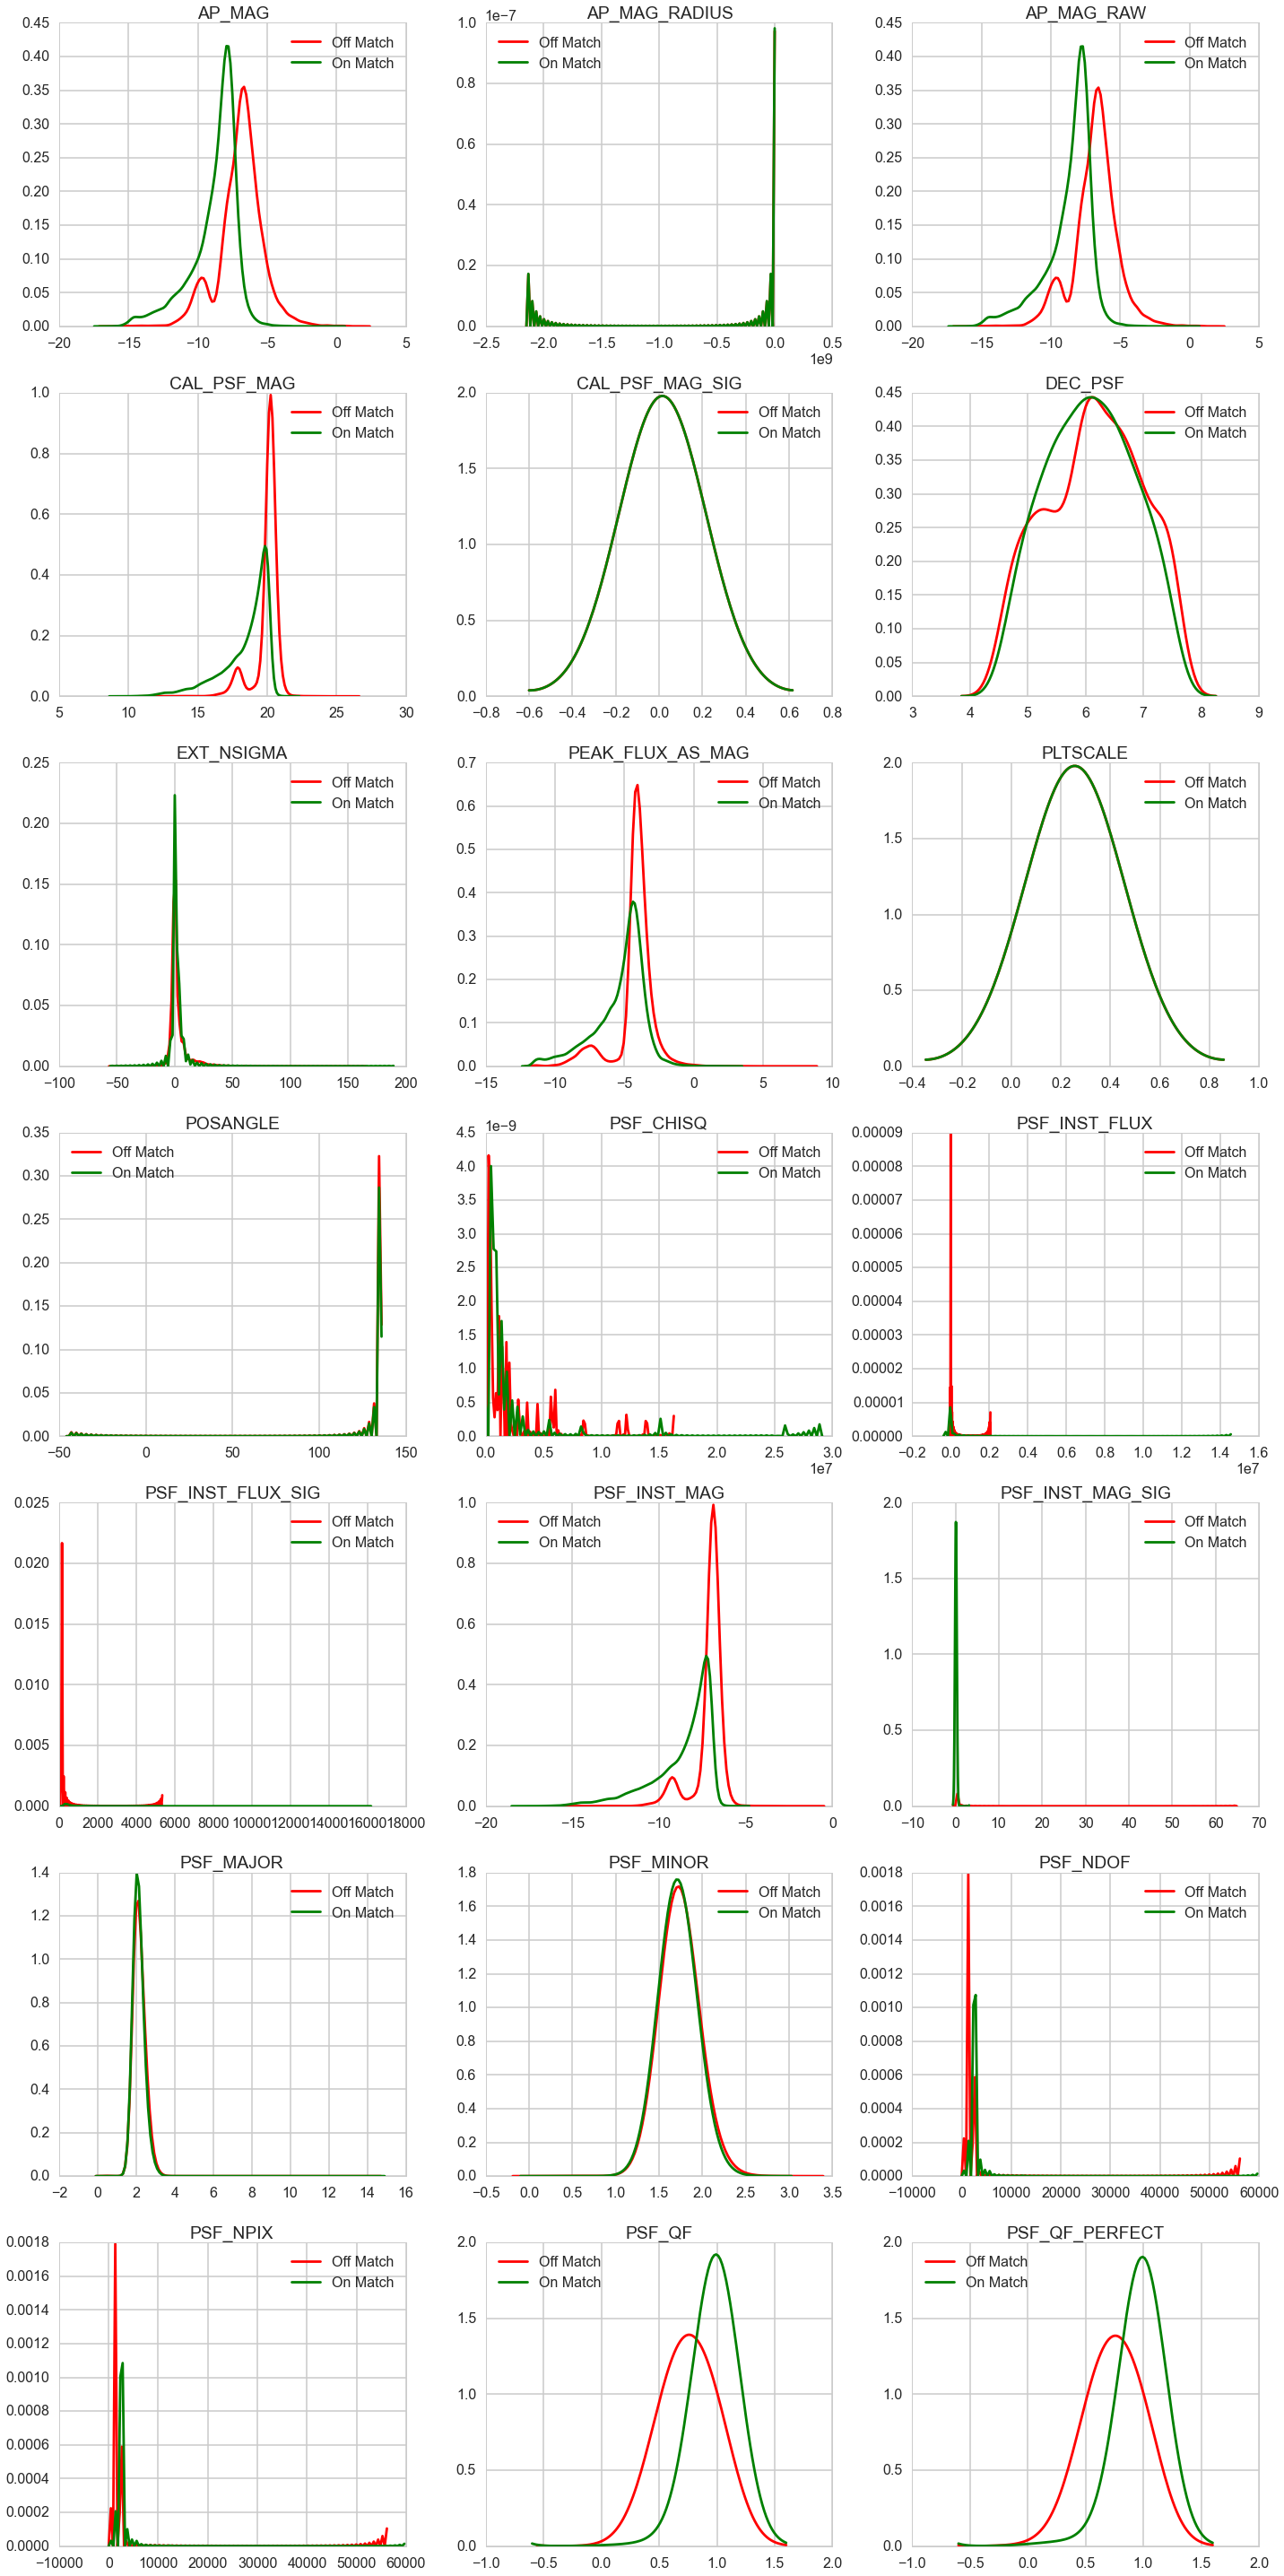

In [328]:
# create kernel density plots for continuous features EDA
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 40), tight_layout=True)
colors=["r","g"]
labels=["Off Match", "On Match"]
for ax, col in zip(axes.ravel(), ccols): 
    for r in [0, 1]:
        color = colors[r]
        label = labels[r]
        mask_r = newdf.on_match == r
        # plot kernel densities - I've picked bandwidth to smooth out the plots a bit, but is this ideal?
        # more on bandwidths https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
        sns.kdeplot(newdf[mask_r][col], bw=.2, ax=ax, color=color, label=label)
        ax.set_title(col)

Kernel density plot for potential indicator features:

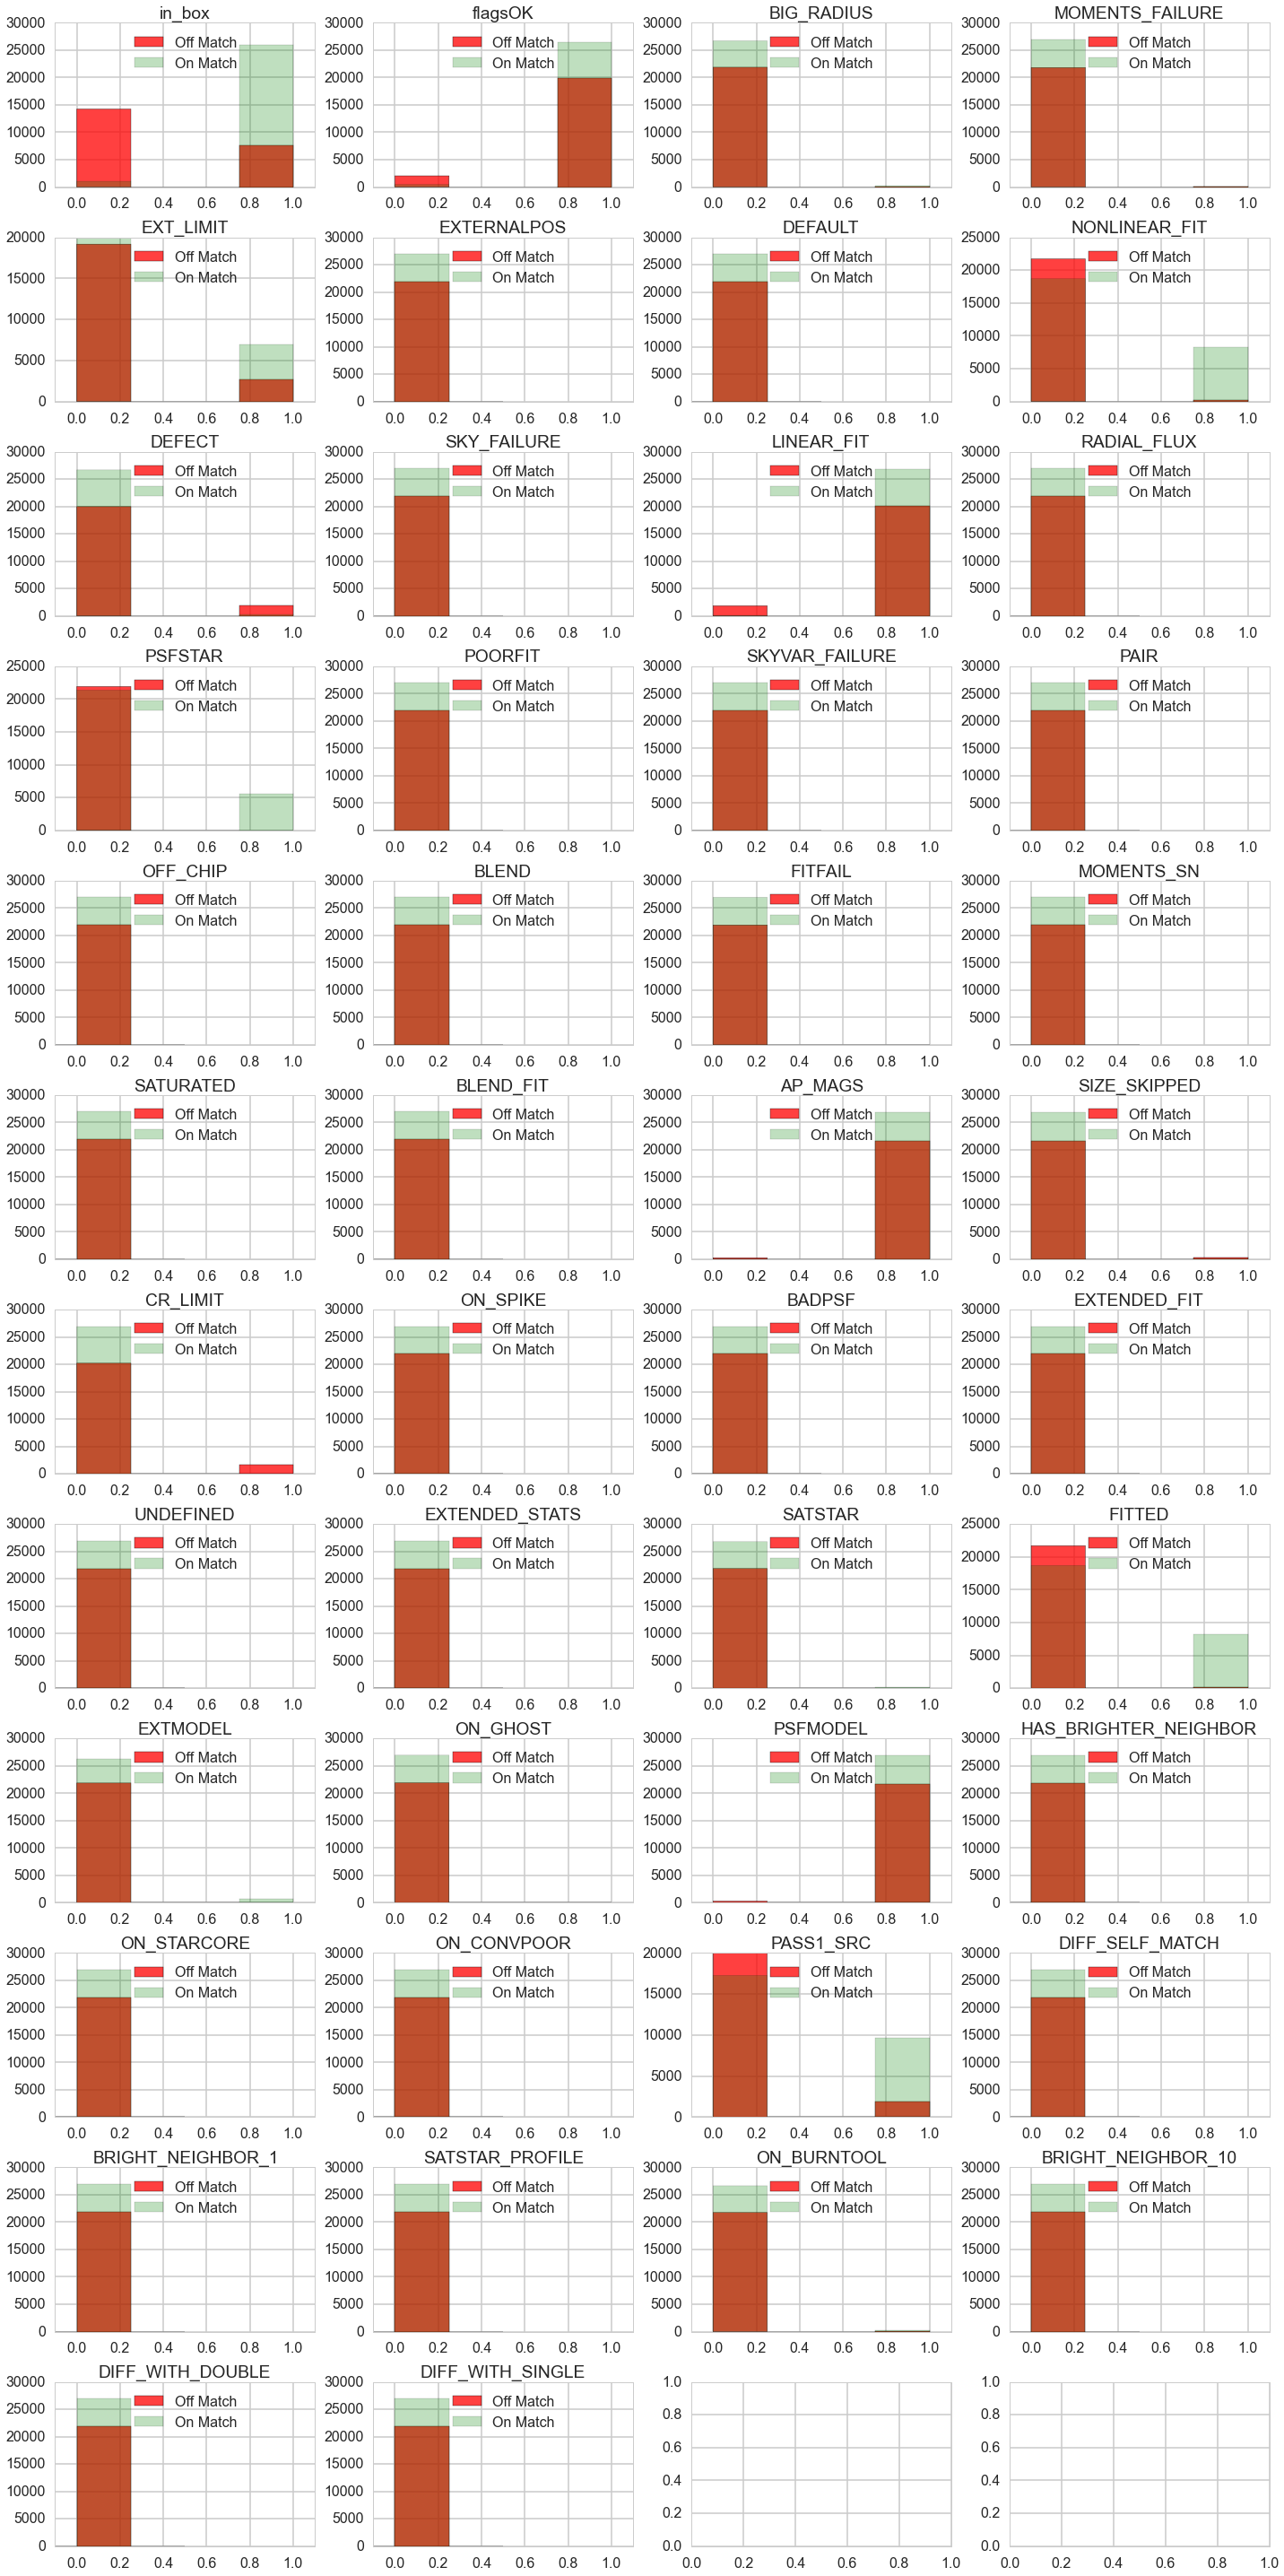

In [329]:
# create kernel density plots for indicator features EDA
fig, axes = plt.subplots(nrows=12, ncols=4, figsize=(20, 40), tight_layout=True)
colors=["r","g"]
labels=["Off Match", "On Match"]
alphas=[.75, .25]
for ax, ind in zip(axes.ravel(), INDICATORS):
    for r in [0, 1]:
        color = colors[r]
        label = labels[r]
        alpha = alphas[r]
        mask_r = newdf.on_match == r
        ax.hist(newdf[mask_r][ind].values, bins=4, color=color, alpha=alpha, label=label, stacked=True)
        ax.set_title(ind)
        ax.set_xlim([-.1,1.1])
        ax.legend(loc='upper center')

good (on_match) detections by chip:

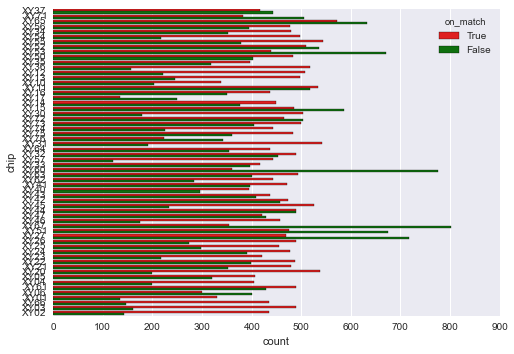

In [330]:
sns.set()
colors=["r","g"]
labels=["Off Match", "On Match"]
alphas=[.5, .5]
sns.countplot(y='chip', hue='on_match', data=newdf, palette=colors)


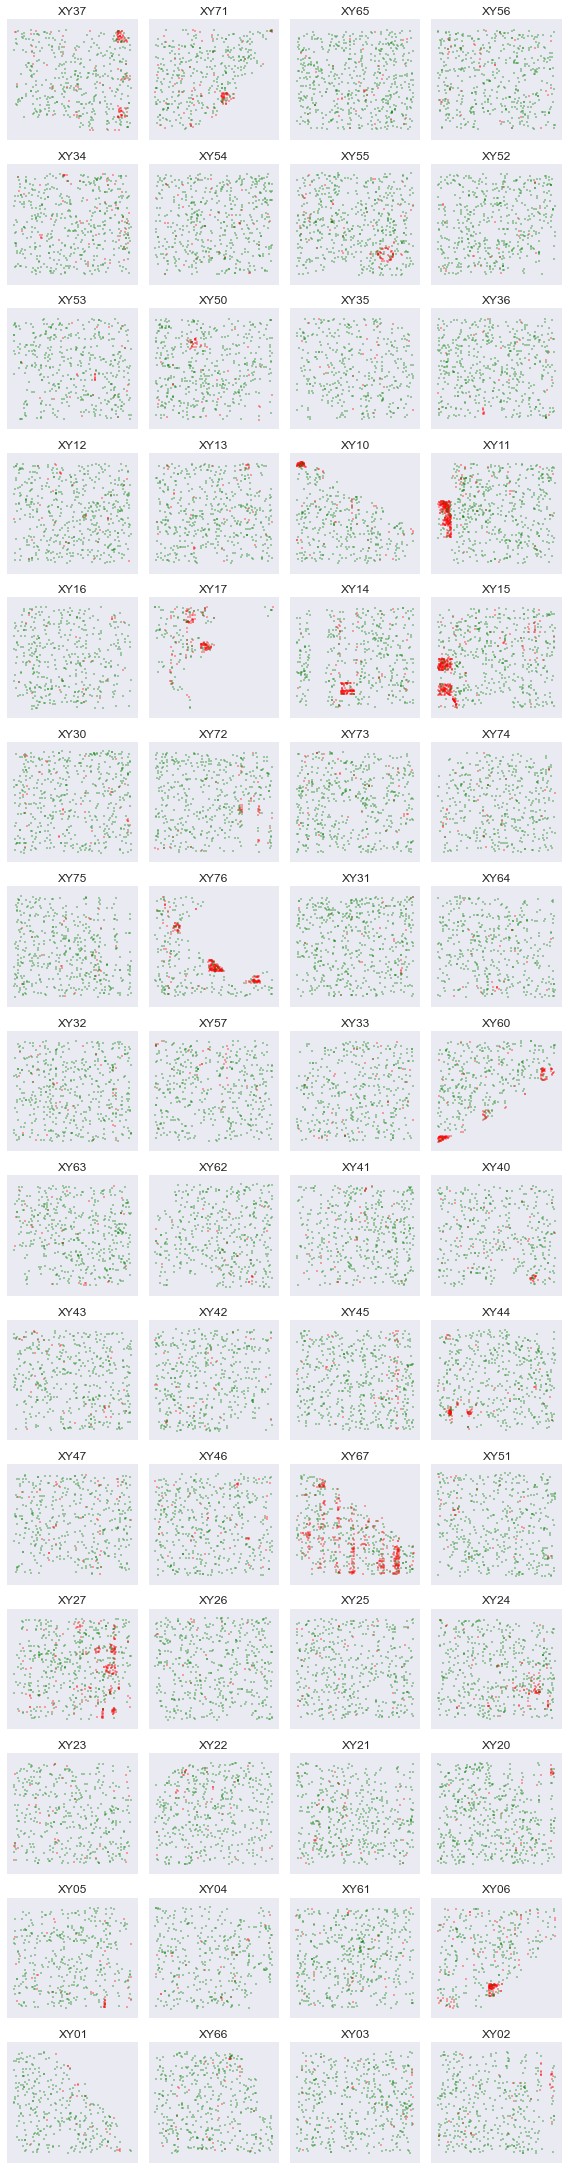

In [331]:
# create kernel density plots for indicator features EDA
gs = gridspec.GridSpec(20, 3,
                       width_ratios=[1,1],
                       height_ratios=[1,1]
                       )

from itertools import product 

colors=["r","g"]
labels=["Off Match", "On Match"]
alphas=[.5, .5]

#plt.close('all')
fig = plt.figure()

nrows = 15
ncols = 4
gs = gridspec.GridSpec(nrows, ncols)
#ax = plt.subplot(gs[0, 0])
        
colors=["r","g"]
#fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40), tight_layout=True)
for chip, (c, d) in zip(chip_dict.keys(), product(range(nrows), range(ncols))):
    ax = plt.subplot(gs[c, d])
    #print chip, c, d
    x = newdf[newdf.chip==chip].X_PSF
    y = newdf[newdf.chip==chip].Y_PSF
    for r in [0, 1]:
        color = colors[r]
        label = labels[r]
        alpha = alphas[r]
        mask_r = newdf.on_match == r
        mask_r = mask_r \
                & (newdf.flagsOK) \
                & (newdf.in_box) & (newdf.magOK) \
                & (newdf.PSF_QF_PERFECT > 0.85) \
                & (newdf.snr >= 5)
        ax.scatter(x[mask_r], y[mask_r], color=color, alpha=alpha, s=2.0)
        ax.set_title(chip, fontsize=12)
        ax.legend(loc='upper center')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
gs.tight_layout(fig, rect=[0, 0, 1.0, 5.5])

It looks to me that are couple of remaining types of common false detections after these cuts. These are chip specific.

1) There are some additional columns and rows that are predominantly bad.
2) There are some sub-cells that are almost entirely bad.

And then there are some other features that seem to be connected to internal reflections, or something like that.

Here are some steps for generating masks:

* Generate a list of smf files

* Open each file in sequence

* Call smf2pandas to get the chip dictionaries

* Loop through the chips to update the bad pixel masks--this is just recording how many detections in each region are on_known or not.

The bad pixel masks might be very large (1.4 Gigapixels) if kept at full resolution.  The challenge is doing that in a manageable way.

In [332]:
# Generate a list of smf data files
from os import listdir
from os.path import isfile, join
mypath = 'data/'
smffiles = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f)) & f.endswith('.smf')]

In [333]:
%%time
# Open those files in sequence
chip_dict_list = []
#df_list = []
for i, smf in enumerate(smffiles[0:200]):
    print i, smf
    chip_dict, df = smf2pandas(smf, FLAGS_dict=FLAGS_dict, FLAGS2_dict=FLAGS2_dict)
    chip_dict_list.append(chip_dict)
    #df_list.append(df)

0 data/o5895g0004o.424868.cm.333484.n.smf
y 5.754165 6.050334 55895.1872537
1 data/o5895g0005o.424869.cm.333488.n.smf
y 5.961855 3.216078 55895.1877649
2 data/o5895g0006o.424870.cm.333490.n.smf
y 8.291938 4.858724 55895.1882521
Wall time: 24.6 s


In [334]:
%%time
# This routine is iterating over a large sample of exposures in the chip_dict_list.
# It takes all of the detections that do not coincide with a known star and figures
# out which chip cell the detection belongs to.  It then tallies up those counts.
#
# Note: an earlier version of this routine was not accounting for possible bursts 
# of detections in a single exposure.  Now it is by taking the median rate over many 
# exposures are representative.
#
cells_dict = collections.defaultdict(lambda: np.array([], dtype=np.int32))
for chip_dict in chip_dict_list:
    for chip, df in chip_dict.iteritems():
        cell_array = np.zeros((8, 8), dtype=np.int32)
        # Need to add the MPs here
        x = df[(df.on_star == False)].X_PSF.values
        y = df[(df.on_star == False)].Y_PSF.values
        for (cx, cy) in np.nditer(whichCell(x, y)):
            cx = int(cx)
            cy = int(cy)
            cell_array[cx, cy] += 1
        #cells_dict[chip] += cell_array
        cells_dict[chip] = np.append(cells_dict[chip], cell_array)

Wall time: 577 ms


In [335]:
for chip, val in cells_dict.iteritems():
#     cells_dict[chip] = np.median(cells_dict[chip].reshape((200,8,8)), axis=0) # Edited, I don't have 200 smfs
    cells_dict[chip] = np.median(cells_dict[chip].reshape((len(chip_dict_list),8,8)), axis=0)

In [336]:
cells_vec = np.empty([0])
for chip, v in cells_dict.iteritems():
    cells_vec = np.append(cells_vec, v.flatten())

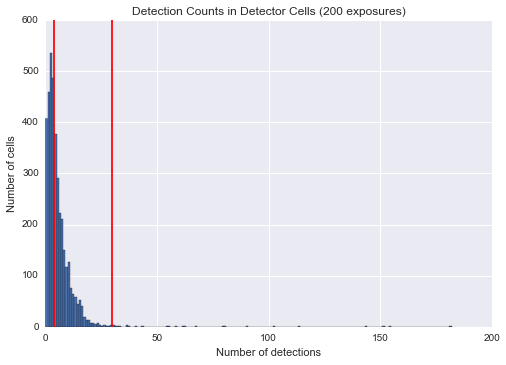

In [337]:
n, nbins, patches = plt.hist(cells_vec, bins=int(cells_vec.max()))
plt.title("Detection Counts in Detector Cells (200 exposures)")
plt.axvline(4, color='red')
plt.axvline(30, color='red')
plt.xlim(0, 200)
plt.xlabel("Number of detections")
plt.ylabel("Number of cells")

In [338]:
cells_dict['XY01']

array([[  3.,   1.,   2.,   0.,   1.,   1.,   5.,   9.],
       [  2.,   1.,   1.,   1.,   0.,   3.,   2.,   0.],
       [  3.,   1.,   1.,   2.,   1.,   2.,  15.,   0.],
       [  1.,   3.,   1.,   1.,   3.,   3.,   0.,   0.],
       [  5.,   1.,   1.,   5.,   2.,   0.,   0.,   0.],
       [  3.,   1.,   2.,   1.,   6.,   0.,   0.,   0.],
       [  4.,   2.,   1.,  12.,   0.,   0.,   0.,   0.],
       [  7.,   1.,   5.,   0.,   0.,   0.,   0.,   0.]])

In [339]:
import json
with open('cells_dict_200_med.json', 'r') as fp:
    cells_dict_tosave = json.load(fp)
   
cells_dict = {}
for chip, v in cells_dict_tosave.iteritems():
    cells_dict[chip] = np.array(v)

In [340]:
for chip, v in cells_dict.iteritems():
    print "%s %10d %10d %10d" % (chip, v.sum(), np.median(v), v.max())
    print chip, np.unravel_index(np.argmax(v), (8, 8))

XY62        312          4         14
XY62 (7, 7)
XY65        567          6         22
XY65 (4, 5)
XY11        635          5        182
XY11 (4, 0)
XY56        455          6         25
XY56 (6, 0)
XY34        425          6         18
XY34 (4, 7)
XY54        410          6         16
XY54 (6, 3)
XY55        430          6         14
XY55 (6, 0)
XY52        528          8         17
XY52 (4, 1)
XY53        604         10         16
XY53 (4, 3)
XY50        467          7         14
XY50 (7, 0)
XY35        465          6         17
XY35 (5, 6)
XY36        282          4         14
XY36 (2, 7)
XY12        332          4         18
XY12 (7, 5)
XY13        364          4         14
XY13 (1, 3)
XY10        261          3         21
XY10 (4, 3)
XY37        560          7         71
XY37 (7, 7)
XY30        273          4         28
XY30 (7, 0)
XY17        309          0         73
XY17 (5, 3)
XY14        339          4         15
XY14 (6, 2)
XY15       1059          5        309
XY15 (4, 0)


In [341]:
cells_dict['XY60']

array([[ 14. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  6. ,  20. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  9. ,   5. ,   4. ,  43.5,   0. ,   0. ,   0. ,   0. ],
       [ 12. ,  11. ,  12. ,   5. ,  17. ,   0. ,   0. ,   0. ],
       [ 14. ,  15. ,  16. ,  12. ,   9. ,   7. ,   0. ,   0. ],
       [ 15. ,  15. ,  15. ,  17. ,  12. ,   6. ,   8. ,  53. ],
       [ 17. ,  19. ,  15. ,  16. ,  12. ,  13. ,  11. ,  11. ],
       [ 20. ,  19. ,  15. ,  20.5,  14. ,  15. ,  14. ,  14. ]])

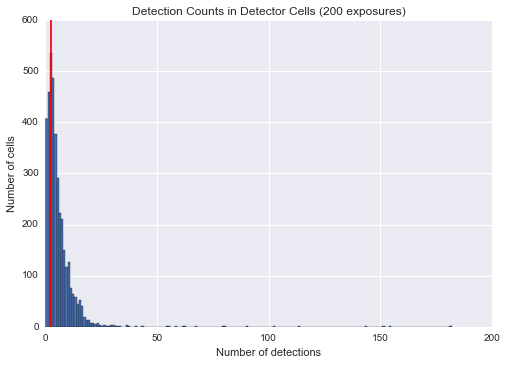

In [342]:
n, nbins, patches = plt.hist(cells_vec, bins=int(cells_vec.max()))
plt.title("Detection Counts in Detector Cells (200 exposures)")
plt.axvline(nbins[np.argmax(n)]+0.5, color='red')
plt.axvline(4000, color='red')
plt.xlim(0, 200)
plt.xlabel("Number of detections")
plt.ylabel("Number of cells")

In [343]:
nbins[np.argmax(n)], np.mean(cells_vec), np.median(cells_vec), np.std(cells_vec)

(2.0, 5.3773437499999996, 4.0, 8.0542792214865067)

In [344]:
# How many bad cells are there in total?
count_thresh=30
print (cells_vec > count_thresh).sum(), 'bad cells out of ', cells_vec.shape[0], 'total cells.'
print cells_vec[cells_vec>count_thresh].sum(), "bad cell detections out of ", \
    cells_vec.sum(), "total detections "
print "for a fraction of: ", cells_vec[cells_vec>count_thresh].sum() / cells_vec.sum()

29 bad cells out of  3840 total cells.
2011.0 bad cell detections out of  20649.0 total detections 
for a fraction of:  0.0973897041019


This implies that about 2% of the cells are defective and that these defective cells account for 10% of the total detections.

In [345]:
print "The bad cells are: "
bad_cell_dict=collections.defaultdict(bool)
for chip, v in cells_dict.iteritems():
    high_cells = np.where(v>count_thresh)
    indices = zip(*high_cells)
    for cx, cy in indices:
        bad_cell_dict[(chip,(cx,cy))] = True
        print chip, cx, cy

def in_bad_cell(chip, x, y, bad_cell_dict=bad_cell_dict):
    return bad_cell_dict[(chip, whichCell(x,y))]

print 'position 100, 100 in chip XY67 is bad: ', in_bad_cell('XY67', 100, 100)

The bad cells are: 
XY11 2 0
XY11 3 0
XY11 4 0
XY37 4 7
XY37 7 7
XY17 5 3
XY17 7 2
XY15 0 1
XY15 1 0
XY15 2 0
XY15 4 0
XY15 5 0
XY72 3 5
XY76 1 5
XY76 2 3
XY32 7 6
XY57 7 0
XY60 2 3
XY60 5 7
XY71 2 4
XY45 2 6
XY45 7 6
XY44 1 0
XY44 1 2
XY44 2 1
XY67 0 0
XY67 0 1
XY67 0 2
XY67 0 3
XY67 0 5
XY67 0 6
XY67 0 7
XY67 1 0
XY67 1 3
XY67 1 6
XY67 2 0
XY67 2 2
XY67 2 3
XY67 3 1
XY67 6 1
XY27 0 6
XY27 3 6
XY27 4 6
XY27 5 6
XY27 6 6
XY27 7 4
XY27 7 6
XY05 1 7
XY06 0 0
XY06 1 3
XY06 2 4
position 100, 100 in chip XY67 is bad:  True


In [346]:
good_cell_mask = np.array(map(lambda (c, x, y): not(in_bad_cell(c, x, y)), zip(newdf['chip'], newdf['X_PSF'], newdf['Y_PSF'])))

In [347]:
float((~good_cell_mask).sum())/good_cell_mask.shape[0]

0.052521696413951206

In [348]:
newdf['cell_good'] = pd.Series(good_cell_mask, index=newdf.index)

In [349]:
newdf[0:5]

AP_MAG  AP_MAG_RADIUS  AP_MAG_RAW  CAL_PSF_MAG  CAL_PSF_MAG_SIG  CR_NSIGMA   DEC_PSF  EXT_NSIGMA      FLAGS  FLAGS2  IPP_IDET      KRON_FLUX  KRON_FLUX_ERR  KRON_FLUX_INNER  KRON_FLUX_OUTER  MOMENTS_M3C  MOMENTS_M3S  MOMENTS_M4C  MOMENTS_M4S  MOMENTS_R1  MOMENTS_RH  MOMENTS_XX  MOMENTS_XY  MOMENTS_YY  N_FRAMES  PADDING  PADDING2  PEAK_FLUX_AS_MAG  PLTSCALE   POSANGLE     PSF_CHISQ   PSF_INST_FLUX  PSF_INST_FLUX_SIG  PSF_INST_MAG  PSF_INST_MAG_SIG  PSF_MAJOR  PSF_MINOR  PSF_NDOF  \
0 -16.105915              8  -15.989053    11.544366         0.015625        NaN  5.188569   23.870026  640696327     128         0  2771294.25000    2088.662354    794063.500000    183158.296875     0.193679    -1.979877     0.660624     0.040192    5.168977    1.999534    5.839915   -0.347463   11.006875         0        0         0        -11.385881  0.255615 -44.986790   821271.8125  1693271.125000        1653.803101    -15.571816          0.000977   2.270140   1.697595      2703   
1 -14.943736              8  -14.826873    12.057705         0.015625        NaN  5.153399    4.367692  103825415     128         1   987895.87500    1202.969482    211830.859375     76612.031250     0.269641    -0.458750     0.035072    -0.042921    3.854464    1.843775    5.546052   -0.261767    5.475727         0        0         0        -11.348567  0.255725 -44.969368    69091.5625  1055336.250000        1273.284912    -15.058477          0.001207   2.101094   1.628697      2690   
2 -15.665754              8  -15.548891    12.146197         0.015625        NaN  5.247891   38.314117  103825415     160         2  2104803.50000    1825.540527    879232.437500    309640.843750    -0.308689    -6.184803    -0.249143     0.015020    5.365948    1.728602    8.452147   -0.033962   12.142209         0        0         0        -11.265514  0.255899 -44.971111  1324781.8750   972734.437500        1277.515503    -14.969985          0.001313   2.036710   1.648822      2687   
3 -14.947728              8  -14.830865    14.733263         0.015625        NaN  5.248050   92.086113   36716545      32         3   409750.28125    1009.182800    602965.250000    259217.578125    -0.365963    -5.953179    -0.996090    -0.090508    2.423606    0.776113    4.258163    0.007898   14.550693         0        0         0        -11.234550  0.255900 -44.971077  1095452.8750    89777.585938         808.500732    -12.382919          0.009006   2.036703   1.648822      2687   
4 -14.104372              8  -13.987509          NaN         0.015625        NaN  5.188786         NaN   35651585       0         4   262711.56250    1134.996582     17863.488281    320032.656250     0.343143    -0.294403    -0.227317     0.054171    2.423606    0.478637    0.343924   -0.076929    1.847633         0        0         0        -11.134068  0.255616 -44.986794   542203.1875   -48257.441406         756.796509           NaN          0.015682   2.269076   1.697253      2600   

   PSF_NPIX    PSF_QF  PSF_QF_PERFECT  PSF_THETA    RA_PSF         SKY  SKY_SIGMA        X_PSF  X_PSF_SIG        Y_PSF  Y_PSF_SIG  mp_dec_rate mp_desig  mp_mag  mp_prox  mp_ra_rate  on_star  chip filterID        mag          snr      fwhm  psf_extent BIG_RADIUS MOMENTS_FAILURE EXT_LIMIT EXTERNALPOS DEFAULT NONLINEAR_FIT DEFECT SKY_FAILURE LINEAR_FIT RADIAL_FLUX PSFSTAR POORFIT SKYVAR_FAILURE   PAIR OFF_CHIP  BLEND FITFAIL MOMENTS_SN SATURATED BLEND_FIT AP_MAGS SIZE_SKIPPED CR_LIMIT ON_SPIKE  \
0      2704  0.998480        0.998480   0.573213  4.755702  276.657104  17.481617  1575.474365   0.002078  2030.260132   0.002078          NaN     None     NaN      NaN         NaN        1  XY37        y  11.544366  1112.147383  1.181637    4.084059       True           False      True       False   False          True  False       False       True       False   False   False          False  False    False  False   False      False     False     False    True        False    False    False   
1      2691  0.958371        0.958371  45.229836  4.835

In [350]:
newdf[(newdf.mp_desig !='None')].shape

(73, 113)

In [351]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

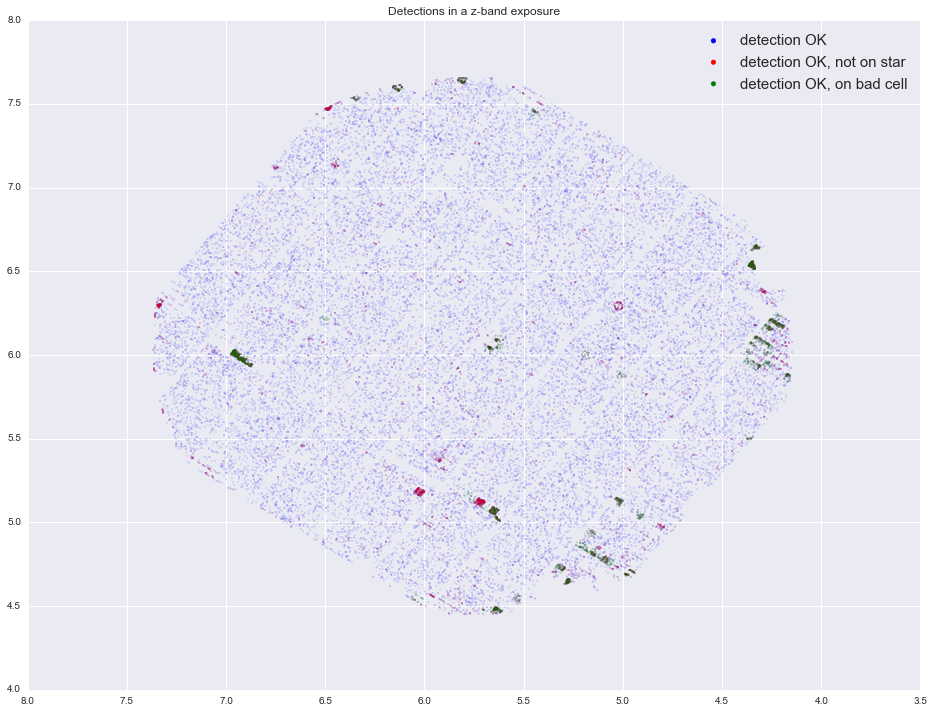

In [352]:
s1 = plt.scatter(newdf[good_mask].RA_PSF, newdf[good_mask].DEC_PSF, s=0.1, color='blue', label='detection OK')
s2 = plt.scatter(newdf[remainder_mask].RA_PSF, newdf[remainder_mask].DEC_PSF, s=0.1, color='red', label='detection OK, not on star')
s3 = plt.scatter(newdf[~good_cell_mask].RA_PSF, newdf[~good_cell_mask].DEC_PSF, s=0.1, color='green', label='detection OK, on bad cell')
plt.title('Detections in a z-band exposure')
leg = plt.legend(markerscale=15, fontsize=15)
plt.gca().invert_xaxis()

This seems to work at the cell level, but it seems like we need finer granularity.  Would we have enough detections to look for bad rows or columns within the cells?

In [353]:
nDets = 100*100000
nCells = 60*8*8
nCellRows = 60*8*8*600
nDets/nCellRows

4

So, we would have to process many more images to be able to reliably find bad rows and colums within a cell, but we can find bad rows and colums within a full chip.

In [354]:
nRows = 60*600
nDets/nRows

277

In [355]:
x = newdf[(newdf.on_star == False)].X_PSF.values
print x.max(), 8*(600+8)-8
y = newdf[(newdf.on_star == False)].Y_PSF.values
print y.max(), 8*(600+10)-10

4844.72 4856
4864.48 4870


In [356]:
%%time
# This routine is also iterating over a large sample of exposures in the chip_dict_list.
# It takes all of the detections that do not coincide with a known star and figures
# out which chip row and column the detection belongs to.  It then tallies up those counts.
#
# Note: this routine is not accounting for possible bursts of detections in a single
# exposure.
#
rows_dict = collections.defaultdict(lambda: np.zeros((4870), dtype=np.int32))
columns_dict = collections.defaultdict(lambda: np.zeros((4870), dtype=np.int32))
for chip_dict in chip_dict_list:
    for chip, df in chip_dict.iteritems():
        row_array = np.zeros((4870), dtype=np.int32)
        column_array = np.zeros((4870), dtype=np.int32)
        # Need to add the MPs here
        x = df[(df.on_star == False)].X_PSF.values
        y = df[(df.on_star == False)].Y_PSF.values
        #x = df.X_PSF.values
        #y = df.Y_PSF.values
        for (cx, cy) in np.nditer((x, y)):
            cx = int(cx)
            cy = int(cy)
            row_array[cy] += 1
            column_array[cx] += 1
        rows_dict[chip] += row_array
        columns_dict[chip] += column_array

Wall time: 552 ms


In [357]:
import json
with open('rows_dict_200.json', 'r') as fp:
    rows_dict_tosave = json.load(fp)

rows_dict = {}
for chip, v in rows_dict_tosave.iteritems():
    rows_dict[chip] = np.array(v)
    
with open('columns_dict_200.json', 'r') as fp:
    columns_dict_tosave = json.load(fp)

columns_dict = {}
for chip, v in columns_dict_tosave.iteritems():
    columns_dict[chip] = np.array(v)

In [358]:
rows_vec = np.empty([0])
for chip, v in rows_dict.iteritems():
    rows_vec = np.append(rows_vec, v.flatten())
    
columns_vec = np.empty([0])
for chip, v in columns_dict.iteritems():
    columns_vec = np.append(columns_vec, v.flatten())

In [359]:
print "Median row detection count", np.median(rows_vec)
print "Max row detection count   ", rows_vec.max()
print 
print "Median column detection ct", np.median(columns_vec)
print "Max column detection ct   ", columns_vec.max()

Median row detection count 15.0
Max row detection count    5323.0

Median column detection ct 10.0
Max column detection ct    10404.0


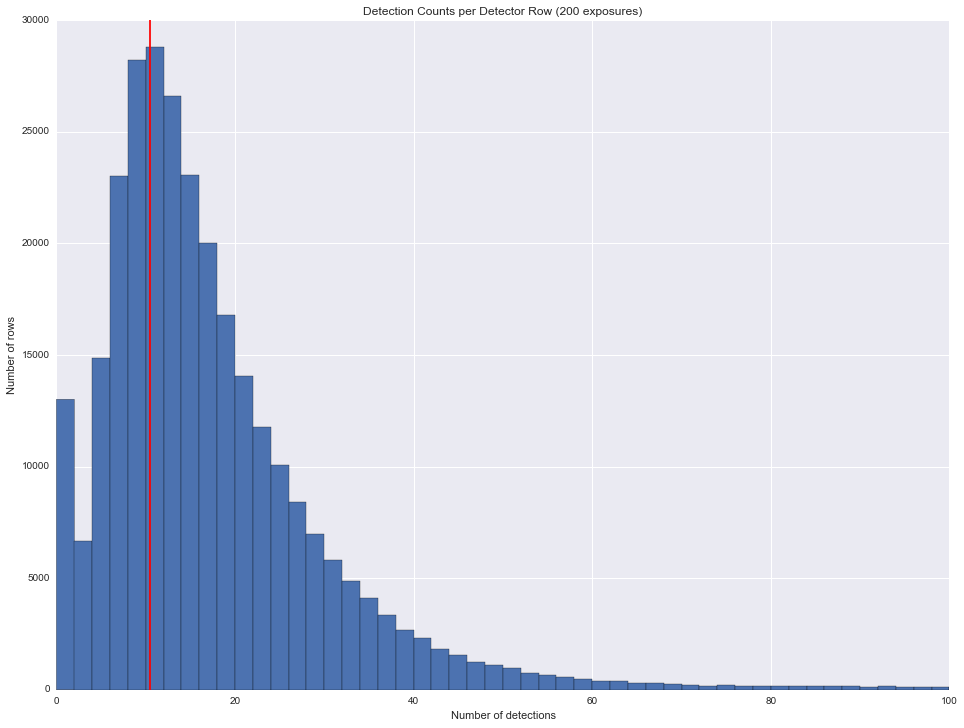

In [360]:
n, nbins, patches = plt.hist(rows_vec, bins=int(rows_vec.max())/2)
plt.title("Detection Counts per Detector Row (200 exposures)")
plt.axvline(nbins[np.argmax(n)]+0.5, color='red')
plt.xlim(0,100)
plt.xlabel("Number of detections")
plt.ylabel("Number of rows")

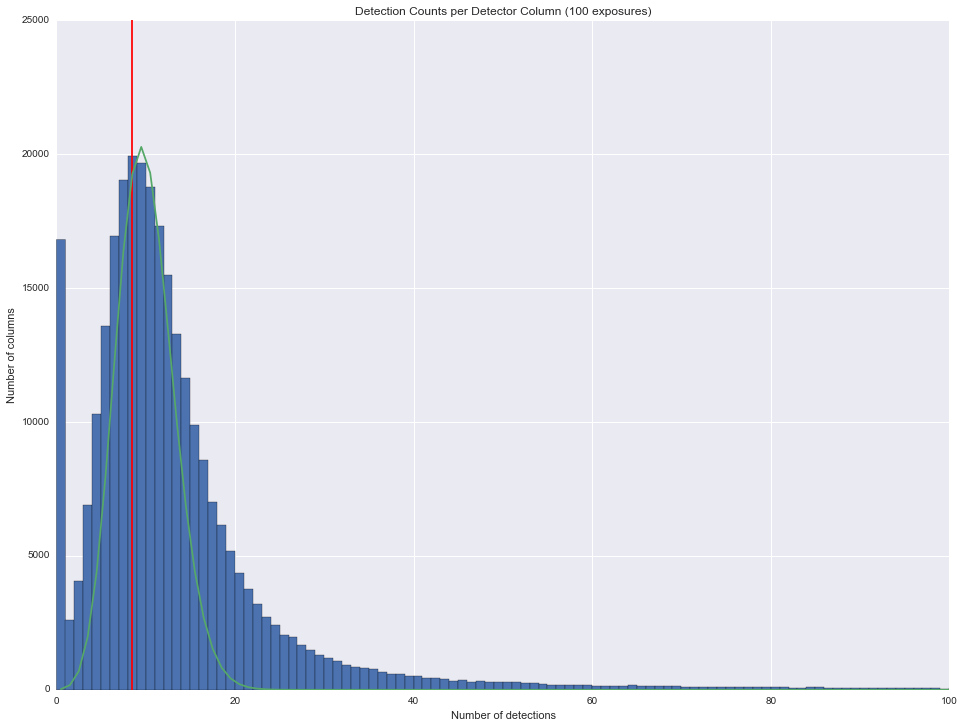

In [361]:
n, nbins, patches = plt.hist(columns_vec, bins=int(columns_vec.max()))
plt.title("Detection Counts per Detector Column (100 exposures)")
plt.axvline(nbins[np.argmax(n)]+0.5, color='red')
#plt.axvline(60, color='red')
plt.xlim(0,100)
#plt.ylim(0,1000)
plt.xlabel("Number of detections")
plt.ylabel("Number of columns")

# I tested and found that this is not well modeled by a single Poisson distribution.  
# The tail is much too broad.  However, since the distribution is summed over a bunch of
# chip the resulting distribution might be the sum of Poisson distributions with different
# means.  The real detections might have similar means across different chips, but the false
# detections might have different rates, since those rates depend up the details of chip
# defects.

nbins
# calculate binmiddles
midbins = 0.5*(nbins[1:] + nbins[:-1])

from scipy.misc import factorial

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

plt.plot(midbins, 160000.*poisson(midbins, 10))

In [362]:
row_thresh = 70
column_thresh = 70

In [363]:
#print "The bad rows are: "
bad_row_dict=collections.defaultdict(bool)
for chip, v in rows_dict.iteritems():
    high_rows = np.where(v>row_thresh)
    for row in high_rows[0]:
        #print chip, row
        bad_row_dict[(chip, row)] = True

def in_bad_row(chip, x, y, bad_row_dict=bad_row_dict):
    return bad_row_dict[(chip, int(y))]

#print "The bad columns are: "
bad_column_dict=collections.defaultdict(bool)
for chip, v in columns_dict.iteritems():
    high_columns = np.where(v>column_thresh)
    for column in high_columns[0]:
        #print chip, column
        bad_column_dict[(chip, column)] = True

def in_bad_column(chip, x, y, bad_column_dict=bad_column_dict):
    return bad_column_dict[(chip, int(x))]


print 'position 4, 208 in chip XY03 is bad: ', in_bad_row('XY03', 208, 4)

position 4, 208 in chip XY03 is bad:  True


In [364]:
good_column_mask = np.array(map(lambda (c, x, y): not(in_bad_column(c, x, y)), zip(newdf['chip'], newdf['X_PSF'], newdf['Y_PSF'])))
good_row_mask = np.array(map(lambda (c, x, y): not(in_bad_row(c, x, y)), zip(newdf['chip'], newdf['X_PSF'], newdf['Y_PSF'])))
newdf['row_good'] = pd.Series(good_row_mask, index=newdf.index)
newdf['column_good'] = pd.Series(good_column_mask, index=newdf.index)

# good_mask refers to detections that pass all the various checks
good_mask = flag_mask & magOK_mask & snr_mask & qfp_mask & good_cell_mask & good_column_mask & good_row_mask

# remainder_mask refers to detections that pass all the tests and which are not on a star.
remainder_mask = good_mask & offStar_mask

print float(remainder_mask.sum())/newdf.shape[0]
print remainder_mask.sum()
print (~offStar_mask & good_mask).sum()
print (~offStar_mask).sum()

0.0558989683969
2731
24402
26884


In [365]:
newdf['valid_match'] = newdf.on_match & newdf.row_good & newdf.column_good & newdf.cell_good # FGV: added

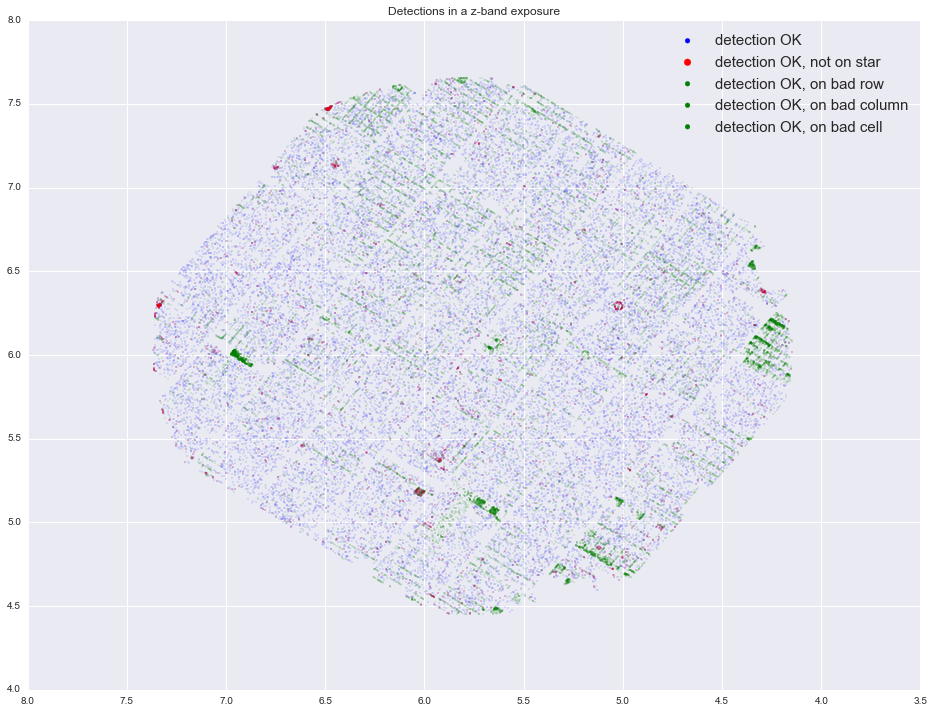

In [366]:
s1 = plt.scatter(newdf[good_mask].RA_PSF, newdf[good_mask].DEC_PSF, s=0.1, color='blue', label='detection OK')
s2 = plt.scatter(newdf[remainder_mask].RA_PSF, newdf[remainder_mask].DEC_PSF, s=0.2, color='red', label='detection OK, not on star')
s3 = plt.scatter(newdf[~good_row_mask].RA_PSF, newdf[~good_row_mask].DEC_PSF, s=0.1, color='green', label='detection OK, on bad row')
s4 = plt.scatter(newdf[~good_column_mask].RA_PSF, newdf[~good_column_mask].DEC_PSF, s=0.1, color='green', label='detection OK, on bad column')
s5 = plt.scatter(newdf[~good_cell_mask].RA_PSF, newdf[~good_cell_mask].DEC_PSF, s=0.1, color='green', label='detection OK, on bad cell')

plt.title('Detections in a z-band exposure')
leg = plt.legend(markerscale=15, fontsize=15)
plt.gca().invert_xaxis()

<a id='model_selection'></a>
## Model Selection

In [367]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [368]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    
    gs.fit(X, y)
    
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [369]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    
    scaler = StandardScaler()
    Xtrain_scaled = scaler.fit_transform(Xtrain)
    
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain_scaled, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [370]:
import copy

This is a list of possible features based on the exploratory data analysis above.

In [371]:
# features = ['PSF_QF_PERFECT','snr']
features = ['PSF_QF_PERFECT','snr','CR_LIMIT','PSF_THETA','SKY','X_PSF','X_PSF_SIG',
            'Y_PSF','Y_PSF_SIG','EXT_LIMIT','NONLINEAR_FIT','PASS1_SRC']

# features = ['PSF_QF_PERFECT','snr','CR_LIMIT','PSF_THETA','SKY','X_PSF','X_PSF_SIG','chip',
#             'Y_PSF','Y_PSF_SIG','EXT_LIMIT','NONLINEAR_FIT','PASS1_SRC']

target   = 'valid_match' # Added

In [372]:
# The block below filters out records where the value is NaN
# MJH: it's worth noting that this is just filtering out the records where one of the features
# used for training is NaN.
init = np.ones(newdf.shape[0], dtype='int')

numerical_features = copy.deepcopy(features)

# numerical_features.remove('chip')

for i,feature in enumerate(numerical_features):
    temp_mask = ~np.isnan(newdf[feature])
    
    if i == 0:
        final_mask = init & temp_mask
    else:
        final_mask = final_mask & temp_mask

newdf_nonan = newdf[final_mask]

In [373]:
itrain, itest = train_test_split(xrange(newdf_nonan.shape[0]), train_size=0.6)

mask         = np.ones(newdf_nonan.shape[0], dtype='int')
mask[itrain] = 1
mask[itest]  = 0

mask = (mask == 1)

We now run several classifiers with several possible feature specifications.

In [374]:
from sklearn.linear_model import LogisticRegression

In [375]:
clflog = LogisticRegression(penalty='l1')

# parameters = {"C": [1]}
parameters = {"C": [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]}

clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, newdf_nonan, 
                                                 featurenames = features,
                                                 targetname = target, # Edited 
                                                 target1val = 1, 
                                                 mask = mask)

using mask
BEST {'C': 1.0} 0.884848068197 [mean: 0.86838, std: 0.03534, params: {'C': 0.001}, mean: 0.88145, std: 0.03482, params: {'C': 0.01}, mean: 0.88474, std: 0.03159, params: {'C': 0.1}, mean: 0.88485, std: 0.03034, params: {'C': 1.0}, mean: 0.88478, std: 0.03038, params: {'C': 10.0}, mean: 0.88474, std: 0.03037, params: {'C': 100.0}, mean: 0.88471, std: 0.03037, params: {'C': 1000.0}]
############# based on standard predict ################
Accuracy on training data: 0.89
Accuracy on test data:     0.89
[[7761 1595]
 [ 570 9470]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [376]:
print 'snr_thresh =',clflog.coef_[0][0]
print 'qpf_thresh =',clflog.coef_[0][1]

snr_thresh = 9.94011042161
qpf_thresh = 0.00578338014567


In [377]:
from sklearn.svm import SVC

In [378]:
%%time
clfsvm = SVC(kernel="rbf")

parameters = {"C": [1]}
# parameters = {"C": [1e-2, 1e-1, 1e0, 1e1, 1e2]} # Edited the notation

clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, newdf_nonan, 
                                                 featurenames = features,
                                                 targetname = target, # Edited to target var
                                                 target1val = 1, 
                                                 mask = mask)

using mask
BEST {'C': 1} 0.880620101746 [mean: 0.88062, std: 0.03533, params: {'C': 1}]
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.52
[[   76  9280]
 [    0 10040]]
########################################################
Wall time: 8min 59s


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [379]:
from sklearn.ensemble import GradientBoostingClassifier

In [380]:
%%time
parameters = {'n_estimators': [100],
              'max_depth': [6]}
                  
clfgbc = GradientBoostingClassifier()

clfgbc, Xtrain, ytrain, Xtest, ytest = do_classify(clfgbc, parameters, newdf_nonan, 
                                                   featurenames = features,
                                                   targetname = target,
                                                   target1val = 1, 
                                                   mask = mask)

using mask
BEST {'n_estimators': 100, 'max_depth': 6} 0.893269627389 [mean: 0.89327, std: 0.02868, params: {'n_estimators': 100, 'max_depth': 6}]
############# based on standard predict ################
Accuracy on training data: 0.94
Accuracy on test data:     0.91
[[8244 1112]
 [ 597 9443]]
########################################################
Wall time: 1min 44s


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


#### Feature importance:
According to the GBC classifier, the most important features appear to be: PSF_QF_PERFECT, X_PSF, X_PSF_SIG, snr, PSF_THETA

In [381]:
clfgbc.feature_importances_

array([ 0.24787323,  0.1279523 ,  0.03015342,  0.1097626 ,  0.10663686,
        0.13004501,  0.0520347 ,  0.09620295,  0.0552172 ,  0.03377107,
        0.00119336,  0.0091573 ])

```features = ['PSF_QF_PERFECT','snr','CR_LIMIT','PSF_THETA','SKY','X_PSF','X_PSF_SIG',
            'Y_PSF','Y_PSF_SIG','EXT_LIMIT','NONLINEAR_FIT','PASS1_SRC']```

In [382]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [383]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

For the decision tree, at least, it seems like there are only really four classifiers that make a difference. The others all contain roughly the same information.

In [384]:
%%time
clftree = DecisionTreeClassifier(random_state = 0)
tree_params = {"max_depth": range(1,11), "min_samples_split": [1, 5, 10, 50]}
tree_features = ['PSF_QF_PERFECT','snr', "PASS1_SRC", "CR_LIMIT"]
clftree, Xtrain_tree, ytrain_tree, Xtest_tree, ytest_tree=do_classify(clftree, tree_params, newdf_nonan, 
                                                                     featurenames = tree_features,
                                                                     targetname = 'on_match', 
                                                                     target1val = 1, 
                                                                     mask = mask)

using mask
BEST {'min_samples_split': 10, 'max_depth': 7} 0.896981988175 [mean: 0.83569, std: 0.02022, params: {'min_samples_split': 1, 'max_depth': 1}, mean: 0.83569, std: 0.02022, params: {'min_samples_split': 5, 'max_depth': 1}, mean: 0.83569, std: 0.02022, params: {'min_samples_split': 10, 'max_depth': 1}, mean: 0.83569, std: 0.02022, params: {'min_samples_split': 50, 'max_depth': 1}, mean: 0.87110, std: 0.02178, params: {'min_samples_split': 1, 'max_depth': 2}, mean: 0.87110, std: 0.02178, params: {'min_samples_split': 5, 'max_depth': 2}, mean: 0.87110, std: 0.02178, params: {'min_samples_split': 10, 'max_depth': 2}, mean: 0.87110, std: 0.02178, params: {'min_samples_split': 50, 'max_depth': 2}, mean: 0.87918, std: 0.02391, params: {'min_samples_split': 1, 'max_depth': 3}, mean: 0.87918, std: 0.02391, params: {'min_samples_split': 5, 'max_depth': 3}, mean: 0.87918, std: 0.02391, params: {'min_samples_split': 10, 'max_depth': 3}, mean: 0.87918, std: 0.02391, params: {'min_samples_s

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [385]:
%%time
clfforest = RandomForestClassifier()
forest_params = {"n_estimators": [5, 10, 20, 25, 50], "max_depth": range(1,11), "min_samples_split": [1, 5, 10, 50]}
clfforest, Xtrain_tree, ytrain_tree, Xtest_tree, ytest_tree=do_classify(clfforest, forest_params, newdf_nonan, 
                                                                         featurenames = tree_features,
                                                                         targetname = 'on_match', 
                                                                         target1val = 1, 
                                                                         mask = mask)

using mask
BEST {'min_samples_split': 1, 'n_estimators': 25, 'max_depth': 8} 0.899697511343 [mean: 0.84229, std: 0.01243, params: {'min_samples_split': 1, 'n_estimators': 5, 'max_depth': 1}, mean: 0.84652, std: 0.01568, params: {'min_samples_split': 1, 'n_estimators': 10, 'max_depth': 1}, mean: 0.84453, std: 0.02728, params: {'min_samples_split': 1, 'n_estimators': 20, 'max_depth': 1}, mean: 0.84381, std: 0.02545, params: {'min_samples_split': 1, 'n_estimators': 25, 'max_depth': 1}, mean: 0.85460, std: 0.02093, params: {'min_samples_split': 1, 'n_estimators': 50, 'max_depth': 1}, mean: 0.84398, std: 0.02704, params: {'min_samples_split': 5, 'n_estimators': 5, 'max_depth': 1}, mean: 0.83903, std: 0.01897, params: {'min_samples_split': 5, 'n_estimators': 10, 'max_depth': 1}, mean: 0.85883, std: 0.01779, params: {'min_samples_split': 5, 'n_estimators': 20, 'max_depth': 1}, mean: 0.83810, std: 0.02132, params: {'min_samples_split': 5, 'n_estimators': 25, 'max_depth': 1}, mean: 0.86161, std

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Increasing the number of features was really critical for getting a better fit! Critically, it cut the number of false negatives by a lot (over 3000 for the `features` matrix vs about 2700 for the `tree_features` feature set) at the cost of only a few more false positives (about a hundred). This is a huge improvement!

Here, I make a visualization of the tree. I needed to type

> pip install pydot2

at the command line. **Make sure you are not using pydot**. Make sure you upgrade it as well to the most recent version. You also might need to install pyparser first. To do so, use

> pip install pyparsing

And then upgrade. *I cannot emphasize enough that this will not work if you do not upgrade.*

You may also need to install graphviz:

> brew install graphviz

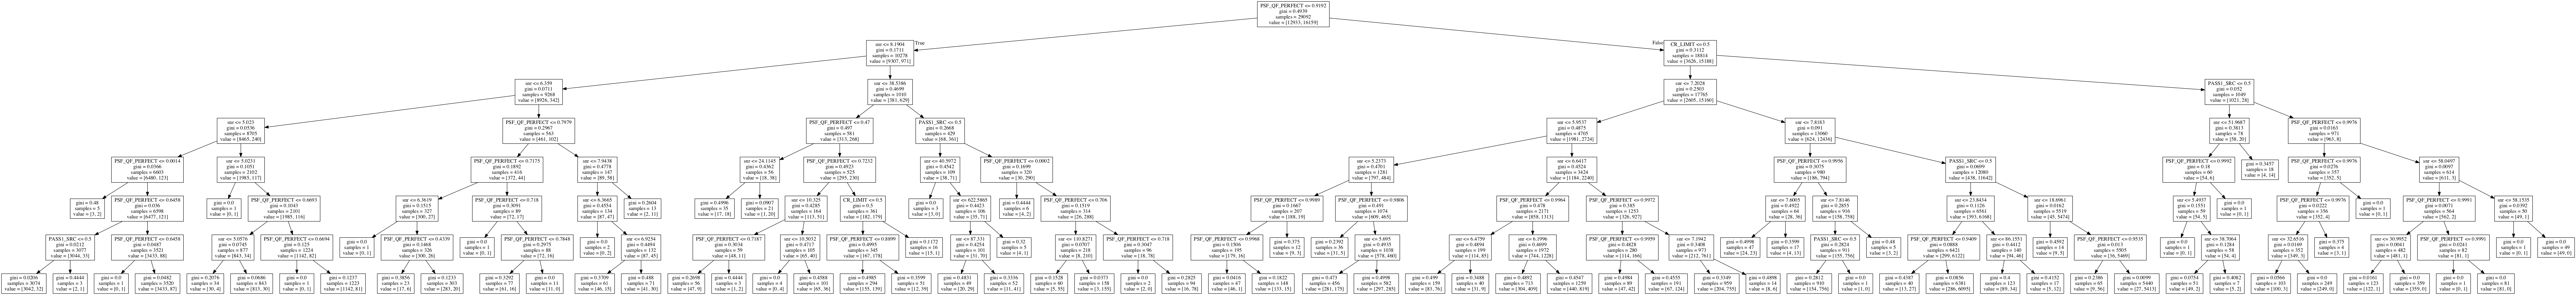

In [79]:
from StringIO import StringIO  
import pyparsing
import pydot
from IPython.display import Image  
from sklearn import tree
import subprocess
dot_data = StringIO()  
out = tree.export_graphviz(clftree, out_file=dot_data,feature_names=tree_features)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [400]:
def get_code(tree, feature_names, target_names,
             spacer_base="    "):
    """Produce psuedo-code for decision tree.

    Args
    ----
    tree -- scikit-leant DescisionTree.
    feature_names -- list of feature names.
    target_names -- list of target (class) names.
    spacer_base -- used for spacing code (default: "    ").

    Notes
    -----
    based on http://stackoverflow.com/a/30104792.
    """
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth):
        spacer = spacer_base * depth
        if (threshold[node] != -2):
            print(spacer + "if ( " + features[node] + " <= " + \
                  str(threshold[node]) + " ) {")
            if left[node] != -1:
                    recurse(left, right, threshold, features,
                            left[node], depth+1)
            print(spacer + "}\n" + spacer +"else {")
            if right[node] != -1:
                    recurse(left, right, threshold, features,
                            right[node], depth+1)
            print(spacer + "}")
        else:
            target = value[node]
            for i, v in zip(np.nonzero(target)[1],
                            target[np.nonzero(target)]):
                target_name = target_names[i]
                target_count = int(v)
                print(spacer + "return " + str(target_name) + \
                      " ( " + str(target_count) + " examples )")

    recurse(left, right, threshold, features, 0, 0)

In [401]:
get_code(clftree, tree_features, ["observation", "false"])

if ( snr <= 6.02065944672 ) {
    if ( PSF_QF_PERFECT <= 0.964393556118 ) {
        if ( snr <= 5.18319702148 ) {
            if ( PSF_QF_PERFECT <= 0.00144226464909 ) {
                return observation ( 1 examples )
                return false ( 1 examples )
            }
            else {
                if ( snr <= 4.88331890106 ) {
                    if ( PSF_QF_PERFECT <= 0.780663013458 ) {
                        if ( PSF_QF_PERFECT <= 0.252080798149 ) {
                            return observation ( 23 examples )
                            return false ( 2 examples )
                        }
                        else {
                            return observation ( 4906 examples )
                            return false ( 65 examples )
                        }
                    }
                    else {
                        if ( snr <= 1.22741794586 ) {
                            return false ( 1 examples )
                        }
                    

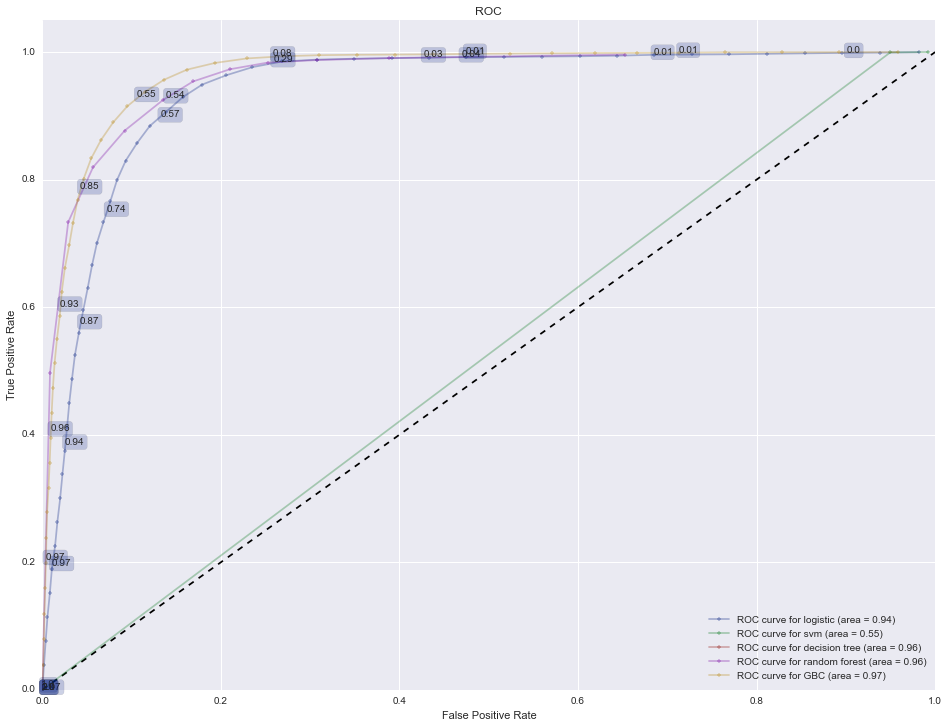

In [402]:
with sns.color_palette("dark"):
    ax = make_roc("logistic",clflog, ytest, Xtest, None, labe=2050, proba=True,  skip=400)

    make_roc("svm",clfsvm, ytest, Xtest, ax=ax, labe=2050, proba=False, skip=400)
    
    make_roc("decision tree",clftree, ytest_tree, Xtest_tree, ax=ax, labe=2050, proba=True,  skip=400)
    make_roc("random forest",clfforest, ytest_tree, Xtest_tree, ax=ax, labe=2050, proba=True,  skip=400)
    
    make_roc("GBC",clfgbc, ytest, Xtest, ax=ax, labe=2050, proba=True,  skip=400)

In [403]:
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import f_classif

fprselector = SelectFpr(score_func = f_classif, alpha = 0.05)

In [404]:
%%time
pipe_params = {'log__C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]}

pipelog = Pipeline([('selector', fprselector),
                     ('log', LogisticRegression(penalty='l2'))])
                                 
pipelog1,Xtrain, ytrain, Xtest, ytest = do_classify(pipelog, pipe_params, newdf_nonan, 
                                                 featurenames = features,
                                                 targetname = target,
                                                 target1val = 1, 
                                                 mask = mask)

using mask
BEST {'log__C': 10.0} 0.884607452221 [mean: 0.87058, std: 0.03647, params: {'log__C': 0.001}, mean: 0.87543, std: 0.03485, params: {'log__C': 0.01}, mean: 0.88409, std: 0.03226, params: {'log__C': 0.1}, mean: 0.88430, std: 0.03042, params: {'log__C': 1.0}, mean: 0.88461, std: 0.03005, params: {'log__C': 10.0}, mean: 0.88450, std: 0.03005, params: {'log__C': 100.0}, mean: 0.88447, std: 0.03005, params: {'log__C': 1000.0}]
############# based on standard predict ################
Accuracy on training data: 0.89
Accuracy on test data:     0.89
[[7721 1635]
 [ 593 9447]]
########################################################
Wall time: 5.38 s


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [405]:
%%time
pipe_params = {'gbc__n_estimators': [50,100],
               'gbc__max_depth': [5,6]}

pipegbc = Pipeline([('selector', fprselector),
                     ('gbc', GradientBoostingClassifier())])
                                 
pipegbc1, Xtrain, ytrain, Xtest, ytest = do_classify(pipegbc, pipe_params, newdf_nonan, 
                                                     featurenames = features,
                                                     targetname = target,
                                                     target1val = 1, 
                                                     mask = mask)

using mask
BEST {'gbc__max_depth': 5, 'gbc__n_estimators': 100} 0.896191392823 [mean: 0.89564, std: 0.02321, params: {'gbc__max_depth': 5, 'gbc__n_estimators': 50}, mean: 0.89619, std: 0.02299, params: {'gbc__max_depth': 5, 'gbc__n_estimators': 100}, mean: 0.89619, std: 0.02318, params: {'gbc__max_depth': 6, 'gbc__n_estimators': 50}, mean: 0.89557, std: 0.02343, params: {'gbc__max_depth': 6, 'gbc__n_estimators': 100}]
############# based on standard predict ################
Accuracy on training data: 0.93
Accuracy on test data:     0.91
[[8125 1231]
 [ 593 9447]]
########################################################
Wall time: 2min 43s


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


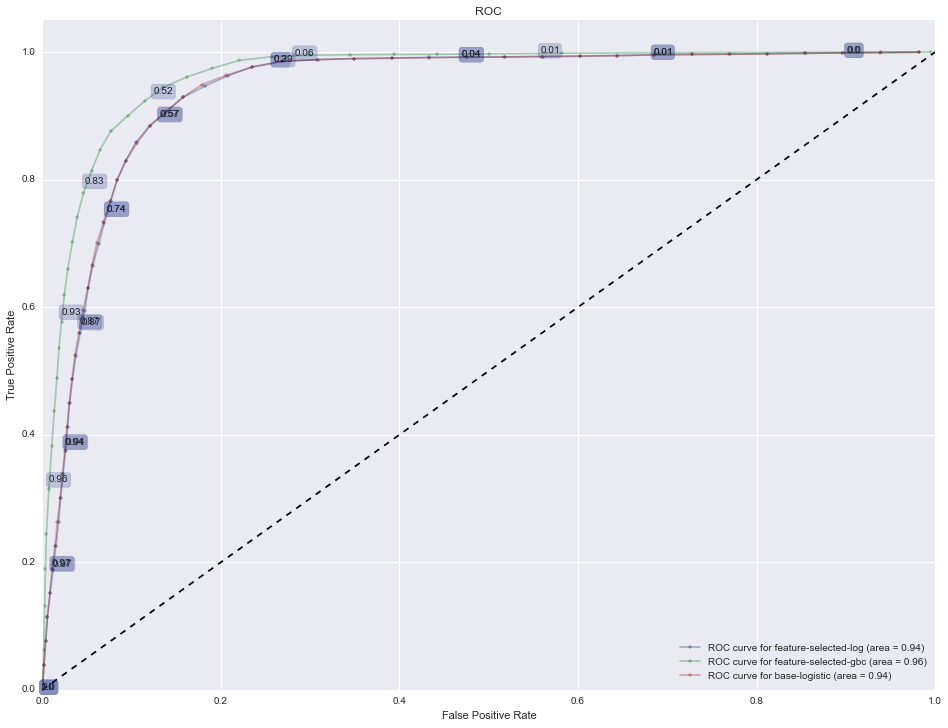

In [406]:
with sns.color_palette("dark"):
    ax = make_roc("feature-selected-log",pipelog1, ytest, Xtest, None, labe=2050, proba=True,  skip=400)
    make_roc("feature-selected-gbc",pipegbc1, ytest, Xtest, ax=ax, labe=2050, proba=True,  skip=400)
    make_roc("base-logistic",clflog, ytest, Xtest, ax=ax, labe=2050, proba=True,  skip=400)

Feature selection doesn't make a difference, and GBC is still the best choice.

### Balancing classes

In [407]:
positive_count = sum(newdf_nonan.on_match)
negative_count = newdf_nonan.shape[0] - positive_count

print positive_count, negative_count

26865 21623


In [408]:
indices  = np.arange(0, newdf_nonan.shape[0])

new_pos  = np.random.choice(indices[np.array(newdf_nonan.on_match, dtype=pd.Series) == True], size=negative_count, replace=False)

new_ind = np.concatenate((indices[np.array(newdf_nonan.on_match, dtype=pd.Series) == False], new_pos))

new_mask = newdf_nonan.index.isin(new_ind)

### After rebalancing

In [409]:
%%time
pipe_params = {'log__C': [1e-3, 1e-2, 1e-1, 1e0, 1e1]}

pipelog2 = Pipeline([('selector', fprselector),
                     ('log', LogisticRegression())])
                                 
pipelog2, Xtrain, ytrain, Xtest, ytest = do_classify(pipelog2, pipe_params, newdf_nonan, 
                                                     featurenames = features,
                                                     targetname = target,
                                                     target1val = 1, 
                                                     #mask = mask)
                                                     mask = new_mask)

using mask
BEST {'log__C': 10.0} 0.88448814128 [mean: 0.86960, std: 0.03835, params: {'log__C': 0.001}, mean: 0.87817, std: 0.03599, params: {'log__C': 0.01}, mean: 0.88421, std: 0.03259, params: {'log__C': 0.1}, mean: 0.88442, std: 0.03186, params: {'log__C': 1.0}, mean: 0.88449, std: 0.03190, params: {'log__C': 10.0}]
############# based on standard predict ################
Accuracy on training data: 0.89
Accuracy on test data:     0.89
[[2045  443]
 [ 185 2893]]
########################################################
Wall time: 5.34 s


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [143]:
%%time
pipe_params = {'svm__C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
               'svm__gamma': [1e-5,1e-7,1e-9]}

pipesvm2 = Pipeline([('selector', fprselector),
                     ('svm', SVC(kernel='rbf'))])
                                 
pipesvm2,Xtrain, ytrain, Xtest, ytest  = do_classify(pipesvm2, pipe_params, newdf_nonan, 
                                                     featurenames = features,
                                                     targetname = target,
                                                     target1val = 1, 
                                                     mask = new_mask)

using mask
BEST {'svm__C': 1000.0, 'svm__gamma': 1e-05} 0.868771112405 [mean: 0.50910, std: 0.00002, params: {'svm__C': 0.0001, 'svm__gamma': 1e-05}, mean: 0.50910, std: 0.00002, params: {'svm__C': 0.0001, 'svm__gamma': 1e-07}, mean: 0.50910, std: 0.00002, params: {'svm__C': 0.0001, 'svm__gamma': 1e-09}, mean: 0.50910, std: 0.00002, params: {'svm__C': 0.001, 'svm__gamma': 1e-05}, mean: 0.50910, std: 0.00002, params: {'svm__C': 0.001, 'svm__gamma': 1e-07}, mean: 0.50910, std: 0.00002, params: {'svm__C': 0.001, 'svm__gamma': 1e-09}, mean: 0.50910, std: 0.00002, params: {'svm__C': 0.01, 'svm__gamma': 1e-05}, mean: 0.50910, std: 0.00002, params: {'svm__C': 0.01, 'svm__gamma': 1e-07}, mean: 0.50910, std: 0.00002, params: {'svm__C': 0.01, 'svm__gamma': 1e-09}, mean: 0.50914, std: 0.00007, params: {'svm__C': 0.1, 'svm__gamma': 1e-05}, mean: 0.50910, std: 0.00002, params: {'svm__C': 0.1, 'svm__gamma': 1e-07}, mean: 0.50910, std: 0.00002, params: {'svm__C': 0.1, 'svm__gamma': 1e-09}, mean: 0.85

/Users/Freddy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [410]:
%%time
pipe_params = {'gbc__n_estimators': [50,100,150,200,250],
               'gbc__max_depth': [2,3,4,5,6]}

pipegbc2 = Pipeline([('selector', fprselector),
                     ('gbc', GradientBoostingClassifier())])
                                 
pipegbc2, Xtrain, ytrain, Xtest, ytest = do_classify(pipegbc2, pipe_params, newdf_nonan, 
                                                     featurenames = features,
                                                     targetname = target,
                                                     target1val = 1, 
                                                     mask = new_mask)

using mask
BEST {'gbc__max_depth': 4, 'gbc__n_estimators': 50} 0.894086948418 [mean: 0.89292, std: 0.02685, params: {'gbc__max_depth': 2, 'gbc__n_estimators': 50}, mean: 0.89332, std: 0.02809, params: {'gbc__max_depth': 2, 'gbc__n_estimators': 100}, mean: 0.89295, std: 0.02790, params: {'gbc__max_depth': 2, 'gbc__n_estimators': 150}, mean: 0.89311, std: 0.02740, params: {'gbc__max_depth': 2, 'gbc__n_estimators': 200}, mean: 0.89283, std: 0.02773, params: {'gbc__max_depth': 2, 'gbc__n_estimators': 250}, mean: 0.89402, std: 0.02725, params: {'gbc__max_depth': 3, 'gbc__n_estimators': 50}, mean: 0.89304, std: 0.02672, params: {'gbc__max_depth': 3, 'gbc__n_estimators': 100}, mean: 0.89299, std: 0.02718, params: {'gbc__max_depth': 3, 'gbc__n_estimators': 150}, mean: 0.89290, std: 0.02767, params: {'gbc__max_depth': 3, 'gbc__n_estimators': 200}, mean: 0.89285, std: 0.02824, params: {'gbc__max_depth': 3, 'gbc__n_estimators': 250}, mean: 0.89409, std: 0.02786, params: {'gbc__max_depth': 4, 'gbc

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


<a id='cost_profit'></a>
## Cost & Profit Curves

NameError: name 'pipesvm2' is not defined

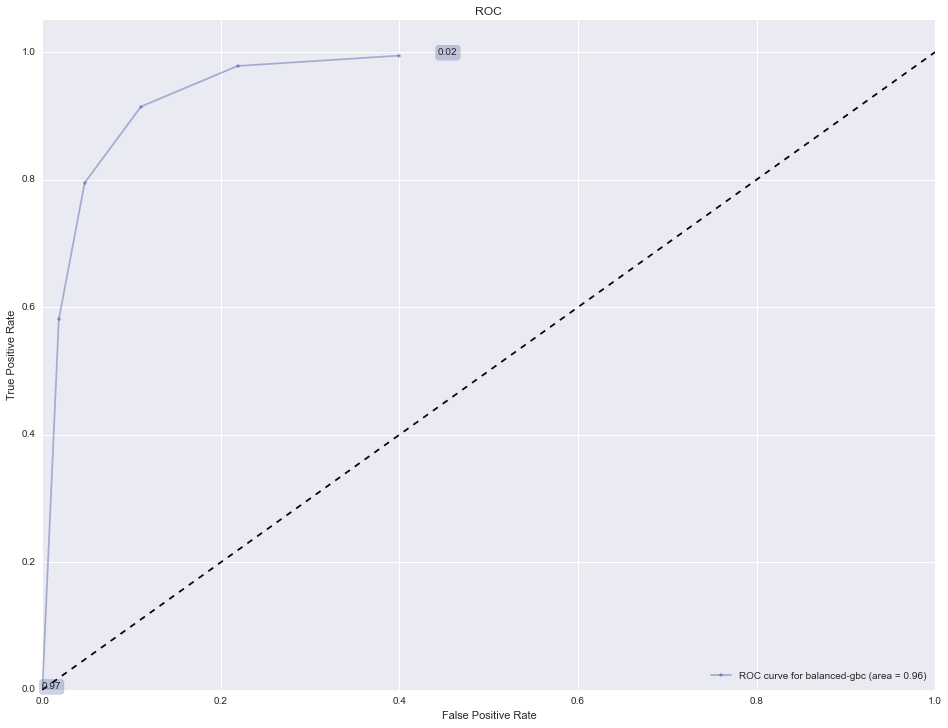

In [412]:
with sns.color_palette("dark"):
    ax = make_roc("balanced-gbc",pipegbc2, ytest, Xtest, None, labe=2050, proba=True,  skip=400)
#     make_roc("balanced-logistic",pipelog2, ytest, Xtest, ax=ax, labe=2050, proba=True,  skip=400)
    make_roc("balanced-svm",pipesvm2, ytest, Xtest, ax=ax, labe=2050, proba=False,  skip=400)
    
    make_roc("random-forest",clfforest, ytest_tree, Xtest_tree, ax=ax, labe=2050, proba=True,  skip=400)

Balancing also doesn't make a big deal. In face, the random forest outperformed the balanced GBC, which previously was a better choice on the ROC curve.

In [ ]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc

In [ ]:
def av_profit(tpr, fpr, util, priorp, priorn):
    """
    Function
    --------
    av_profit

    Inputs
    ------
    tpr: true positive rate
    fpr: false positive rate
    util: utility matrix for this problem
    priorp: the probability of observed +ives (OP) on our test set
    priorn: the probability of observed -ives (ON) on our test set


    Returns
    -------
    The average profit per person at this (fpr, tpr) point in this ROC space.

    Notes
    -----
    see make_profit below for an example of how this is used
    """
    # We multiply the profit for each quadrant of the confusion matrix by its probability.
    tp_profit = (util[1][1] * tpr)
    fn_profit = (util[1][0] * (1.0 - tpr))
    
    tn_profit = (util[0][0] * (1.0 - fpr))
    fp_profit = (util[0][1] * fpr)
    
    # We add the profit for positive and negatives before adjusting for prior probabilities
    profit_from_positives = tp_profit + fn_profit
    profit_from_negatives = tn_profit + fp_profit

    # The expected profit is weighted based on the incidence of +ives vs -ives
    # Avg profit needs to account for imbalances in the outcomes
    adj_profit_from_positives = priorp * profit_from_positives
    adj_profit_from_negatives = priorn * profit_from_negatives
    
    total_profit = adj_profit_from_negatives + adj_profit_from_positives
    
    return total_profit

In [ ]:
def make_profit(name, clf, ytest, xtest, util, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_profit(tpr[i], fpr[i], util, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='utlity curve for %s' % name)
    
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    
    ax.set_xlabel('Proportion of Detections Targeted (%)')
    ax.set_ylabel('Utility per Detection')
    ax.set_title('Utility curves')
    
    return ax

In [ ]:
tnu = 0.1
fnu = -1

fpu = -0.1
tpu = 1

In [ ]:
util_matrix_1 = np.array([[tnu, fpu],[fnu, tpu]])

In [ ]:
tnu = 0.1
fnu = -5

fpu = -0.5
tpu = 1

The logic of our utility matrix is to see what happens depending on how strongly we are concerned about false negatives. In each case, there is a strong penalty for false classification, but false negatives are 10x worse than false positives.

In [ ]:
util_matrix_2 = np.array([[tnu, fpu],[fnu, tpu]])

In [ ]:
with sns.diverging_palette(240, 10, n=2):
    #ax = make_profit("feature-selected-logistic",pipelog2, ytest, Xtest, util_matrix_1, threshold=True, labe=800)
    #ax = make_profit("feature-selected-logistic_high_cost",pipelog2, ytest, Xtest, util_matrix_2, threshold=True, labe=800)
    
    ax = make_profit("feature-selected-gbc",pipegbc2, ytest, Xtest, util_matrix_2, threshold=True, labe=800)
    
#     make_profit("feature-selected-gbc_high_cost",pipegbc2, ytest, Xtest, util_matrix_2, threshold=True, labe=800)
    
#     make_profit("decision tree", clftree, ytest_tree, Xtest_tree, util_matrix_2, ax=ax, threshold=True, labe=800)
    make_profit("random forest", clfforest, ytest_tree, Xtest_tree, util_matrix_2, ax=ax, threshold=True, labe=800)

In [ ]:
newdf.shape, newdf_nonan.shape

## Considering the costs in more detail

### Discoveries from detections

The number of real objects we discover in a search will depend upon the number of real detections of any particular object we can identify in the data.  Suppose there is some minimum number of detections $N_{min}$ we need to discover a moving object and that we have a number of opportunities $N_{tries}$ at getting those detections.  Also suppose that there is known probability that the light from any given object hits "live silicon" on the detector array.  Then the probability of making the detection is

$P(detect) = P(detect|silicon)P(silicon)$

For the Pan-STARRS-1 camera, $P(silicon)\sim 0.8$ (which is unfortunately low).  

We also have
$P(detect|silicon) \sim \frac{TP}{TP+FN} = TPR,$
where TP is the number of true positives (real detections identified as such), FN is the number of false negatives (real detections that are classified as false), and TPR is the true positive rate.

We cannot control $P(silicon)$, but we can try to improve $P(detect|silicon)$.

The probability of getting at least the minimum number of detections is

$P(N\ge N_{min}) = \sum_{i=N_{min}}^{N_{tries}}{N_{tries} \choose i} \left[P(detect)\right]^i \left[1-P(detect)\right]^{(N_{tries} - i)} $

This is obviously a strong function of $P(detect)$, given that $N_{min} = 3-10$, depending upon the technique and what is considered a "discovery."  So we need to increase $P(detect|silicon)$.

### Computational load

The computational load of making those discoveries depends strongly upon the number of detections being considered.  Often it is the case that the computational burden scales as

$C \propto N_{det}^n$, 

where $N_{det}$ is the total number of detections and $n=4-8$.  The total number of detections is composed of real and false detections, so

$N_{det} = TP + FP$, 

where $TN$ and $FP$ are the true and false positives, respectively.  Thus,

$C \propto \left(TP+FP\right)^n$. 

It is reasonable to assume that a fixed amount of computational resource is available for the search.  If a desired search will not fit into the computational budget, then a more restricted search must be undertaken.  This amounts to either limiting $N_{dets}$ to a fixed value or to pursuing algorithmic improvements (i.e. reducing the exponent $n$).  We consider the former.


Up to some limit (i.e. running out of new objects to discover), the expected number of discoveries will be 

$N_{disc} \propto A \cdot P(N\ge N_{tries})$,

where $A$ is the search area and $P(N\ge N_{tries})$ is the probability of accumulating a sufficient number of detections of any given object in that area.  As the calculation above shows, $N_{disc}$ depends on $TPR$ (albeit through a complicated formula).  

As we push up the true positive rate $TPR$ we push up $N_{disc}$.  But as we push up $TPR$ we eventually increase the false positive $FPR$ by following the ROC curve.  That increases the number of false positives in the calculation,  which correspondingly reduces the number of true positives, if the total number of detections is fixed.  That drives down $N_{disc}$.

### Profit function

The number of true positives is given by

$TP = \left(\frac{TP}{TP+FP}\right)\cdot N_{dets} = precision \cdot N_{dets}$,

and the number of discoveries is proportional to the total number of real detections $TP$.  When the total number of false positives FP goes up, we are forced to limit the area $A$ from which we draw data, in order to maintain a manageable value of $N_{dets}$.

In summary, we have

$N_{disc} \propto TP \cdot P(N\ge N_{tries}) \propto \left(precision\cdot N_{dets}\right) \cdot P(N\ge N_{tries}) $

I think this is our profit function.  It can be calculated from a precision-recall plot, correct?

$P(N\ge N_{min}) = \sum_{i=N_{min}}^{N_{tries}}{N_{tries} \choose i} \left[P(detect)\right]^i \left[1-P(detect)\right]^{(N_{tries} - i)} $

In [ ]:
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

from scipy.misc import comb
from scipy.stats import binom

def Pdetection(Nmin, Ntries, Psilicon, Pdet_sil):
    return 1.0 - binom.cdf(Nmin-1,Ntries,Psilicon*Pdet_sil)

Nmin = 3
Ntries = 4
Psilicon = 0.8

x = np.arange(0.0,1.0,0.01)
y_tno = Pdetection(10,16,Psilicon,x)
y_neo = Pdetection(3,4,Psilicon,x)
plt.plot(x, y_tno, label="TNO search")
plt.plot(x, y_neo, label="NEO search")
plt.legend()
plt.xlabel("P(detect)", fontsize=15)
plt.ylabel(r'$P\ (N\geq N_{min})$', fontsize=15)



In [ ]:
def Ndiscoveries(prec,rec, Ntries=6, Nmin=3, Psilicon=0.8):
    score = prec*(1.0-binom.cdf(Nmin-1,Ntries,Psilicon*rec))
    return score

In [ ]:
from sklearn.metrics import precision_recall_curve
def make_discoveries(name, clf, ytest, xtest, util, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
        prec, rec, thresholds=precision_recall_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
        prec, rec, thresholds=precision_recall_curve(ytest, clf.decision_function(xtest))
        
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    ndcs=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_profit(tpr[i], fpr[i], util, priorp, priorn)
        ndisc = Ndiscoveries(prec[i], rec[i])
        ben.append(ev)
        ndcs.append(ndisc)
        percs.append(perc*100)
    
    ax.plot(percs, ndcs, '-', alpha=0.3, markersize=5, label='utlity curve for %s' % name)
    
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ndcs[k]), **label_kwargs)
    ax.legend(loc="lower right")
    
    ax.set_xlabel('Proportion of Detections Targeted (%)')
    ax.set_ylabel('Utility per Detection')
    ax.set_title('Utility Curves')
    
    return ax

In [ ]:
with sns.diverging_palette(240, 10, n=2):
    ax = make_discoveries("feature-selected-gbc",pipegbc2, ytest, Xtest, util_matrix_1, threshold=True, labe=800)
    ax = make_discoveries("feature-selected-logistic",pipelog2, ytest, Xtest, util_matrix_1, threshold=True, labe=800)

In [ ]:
<a id='analysis'></a>
## Final Analysis



<a id='acknowledgements'></a>
## Acknowledgments

We would like to thank a number of people for helpful discussions.  Among these are Rahul Dave, Diana Zhang, Tim Spahr, Michael Lackner.